<a href="https://colab.research.google.com/github/MrVersatile007/AAAI2025/blob/main/AAAI25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and importing required libraries

In [2]:
! pip install shap scikit-network

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 57.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import shap
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import sklearn
from sknetwork.embedding import SVD, Spectral
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns


# Synthetic Graph Generators

In [24]:
class GraphGenerators:

  def __init__(self):
    self.BA = []
    self.BA_I = []
    self.ER = []
    self.NW = []


  def barabasiAlbert(self,n: int, m1:int, m2:int, set1:int, set2:int):
    for i in range(set1):
      self.BA.append(nx.to_numpy_array(nx.barabasi_albert_graph(n, m= m1, seed= i)))
    for i in range(set1, (set1+set2)):
      self.BA.append(nx.to_numpy_array(nx.barabasi_albert_graph(n, m= m2, seed= i)))

    return self.BA

  def barabasiAlbert_internet(self, n: int, m1:int, m2:int, set1:int, set2:int):
    base_1 = nx.random_internet_as_graph(n, seed = 1)
    base_2 = nx.random_internet_as_graph(n, seed = 100)

    for i in range(set1):
      self.BA_I.append(nx.to_numpy_array(nx.barabasi_albert_graph(n, m= m1, seed= i, initial_graph=base_1)))
    for i in range(set1, (set1+set2)):
      self.BA_I.append(nx.to_numpy_array(nx.barabasi_albert_graph(n, m= m2, seed= i, initial_graph=base_2)))

    return self.BA_I

  def erdosRenyi(self, n: int, p1:float, p2:float, set1:int, set2:int):
    for i in range(set1):
      self.ER.append(nx.to_numpy_array(nx.erdos_renyi_graph(n, p = p1, seed= i)))
    for i in range(set1, set1+set2):
      self.ER.append(nx.to_numpy_array(nx.erdos_renyi_graph(n, p = p2, seed= i)))

    return self.ER

  def newmanWatts(self, n:int,  p1:float, p2:float, k1:int, k2:int, set1:int, set2:int):
    for i in range(set1):
      self.NW.append(nx.to_numpy_array(nx.newman_watts_strogatz_graph(n, k1, p1, seed=i)))
    for i in range(set1, set1+set2):
      self.NW.append(nx.to_numpy_array(nx.newman_watts_strogatz_graph(n, k2, p2, seed=i)))

    return self.NW



In [25]:
my_graphs = GraphGenerators()
graphs_type_1 = my_graphs.erdosRenyi(n= 50, p1= 0.4, p2= 0.7, set1=100, set2=100)
# graphs_type_2 = my_graphs.barabasiAlbert(n= 50,m1 = 4, m2 = 7, set1= 100, set2 = 100)
# graphs_type_3 = my_graphs.newmanWatts(n= 50, p1= 0.5, p2= 0.7, k1=3, k2=5, set1=100, set2=100)
# graphs_type_4 = my_graphs.barabasiAlbert_internet(n= 1000, m1= 3, m2= 5, set1=100, set2=100)


# Change-point Detection Algorithm including Graph Feature Extraction

In [26]:
class ChangePointDetection:
  def __init__(self, graphs):
    self.graphs = graphs

###     FEATURE EXTRACTORS

  def deg_centrality(self, graphs):
    self.DC = []
    for graph in graphs:
      G = nx.from_numpy_array(graph, create_using = nx.Graph)
      float_list = [float(val) for val in nx.degree_centrality(G).values()]
      self.DC.append(float_list)
    return self.DC

  def betweenness_centrality(self, graphs):
    self.BC = []
    for graph in graphs:
      G = nx.from_numpy_array(graph, create_using = nx.Graph)
      float_list = [float(val) for val in nx.betweenness_centrality(G).values()]
      self.BC.append(float_list)

    return self.BC

  def eigenvector_centrality(self, graphs):
    self.EV = []
    for graph in graphs:
      G = nx.from_numpy_array(graph, create_using = nx.Graph)
      float_list = [float(val) for val in nx.eigenvector_centrality_numpy(G).values()]
      self.EV.append(float_list)

    return self.EV

  def closeness_centrality(self, graphs):
    self.CC = []
    for graph in graphs:
      G = nx.from_numpy_array(graph, create_using = nx.Graph)
      float_list = [float(val) for val in nx.closeness_centrality(G).values()]
      self.CC.append(float_list)

    return self.CC

  def LSVDembedding(self, graphs):
    self.LSVD = []
    for matrix in graphs:
      degree_matrix = np.diag(np.sum(matrix, axis=1))
      laplacian_matrix = degree_matrix - matrix

      U, S, V = np.linalg.svd(laplacian_matrix)

      self.LSVD.append(S)

    return self.LSVD

  def SVDEmbedding(self, graphs):
    self.SVD = []

    for matrix in graphs:
      # G = nx.from_numpy_array(matrix, create_using = nx.Graph)
      two_dim_mats = SVD(n_components = 2).fit_transform(matrix)
      self.SVD.append(two_dim_mats.flatten())

    return self.SVD

###     MARTINGALE TEST FRAMEWORK

  def strangenessPoint(self, data):
    kmeans = KMeans(n_clusters=1, random_state=7)
    strangeness_values = kmeans.fit_transform(data)
    # strangeness = [value.tolist() for value in strangeness_values]
    return strangeness_values

  def getPValue(self, strangeness):
    rand_term = random.uniform(0, 1)
    term1 = []
    term2 = []
    for i in range(len(strangeness)):
        if strangeness[i] > strangeness[-1]:
            term1.append(i)
        elif strangeness[i] == strangeness[-1]:
            term2.append(i)

    pvalue = (len(term1) + (rand_term * len(term2))) / (i + 1)

    return pvalue

  def martingaleTest(self, data, threshold = 15, epsilon = 0.8, window = 30,  detect=True):
    self.pvalues = []
    self.change_detected_instant = []
    martingale = [1] #Mn+1
    self.saved_martingales = [1] #Mn
    self.T = [] #window
    self.saved_strangeness = []
    for i in range(len(data)):
      if len(self.T) == 0:
        strangeness = [0]
      else:
        #Strangeness one vector has one value
        strangeness = self.strangenessPoint(self.T+ [data[i]])
      self.saved_strangeness.append(strangeness[-1])

      self.pvalues.append(self.getPValue(strangeness))

      martingale.append(martingale[-1] * epsilon * (self.pvalues[-1] ** (epsilon - 1)))

      self.saved_martingales.append(martingale[-1])

      if detect == False:
        self.T.append(data[i])
      else:
        if martingale[-1] > threshold:
          print('CHANGE DETECTED')
          self.T = []
          self.change_detected_instant.append(i)
          martingale[-1] = 1
          self.T.append(data[i])

        else:
          self.T.append(data[i])
          if len(self.T) > window:
            self.T.pop(0)
    print(f'Changes detected at instants: {self.change_detected_instant}')
    print(f'Pvalues : {self.pvalues}')
    print(f'Saved strangeness {self.saved_strangeness}')
    print(f'saved martingales {self.saved_martingales}')
    return {'change_detected_instant' : self.change_detected_instant,
            'pvalues': self.pvalues,
            'strangeness': self.saved_strangeness,
            'martingales': np.array(self.saved_martingales[1:])}

In [27]:
Obj = ChangePointDetection(graphs_type_1)
dc = Obj.deg_centrality(graphs_type_1)
bc = Obj.betweenness_centrality(graphs_type_1)
ev = Obj.eigenvector_centrality(graphs_type_1)
cc = Obj.closeness_centrality(graphs_type_1)
svd = Obj.SVDEmbedding(graphs_type_1)
lsvd = Obj.LSVDembedding(graphs_type_1)
print(f'Degree Centrality Shapes:       {len(dc), len(dc[1])}')
print(f'Betweenness Centrality Shapes:  {len(bc), len(bc[1])}')
print(f'Eigen Vec Centrality Shapes:    {len(ev), len(ev[1])}')
print(f'Closeness Centrality Shapes:    {len(cc), len(ev[1])}')
print(f'SVD Shapes:                     {len(svd), len(svd[1])}')
print(f'LSVD Shapes:                    {len(lsvd), len(lsvd[1])}')

Degree Centrality Shapes:       (200, 50)
Betweenness Centrality Shapes:  (200, 50)
Eigen Vec Centrality Shapes:    (200, 50)
Closeness Centrality Shapes:    (200, 50)
SVD Shapes:                     (200, 100)
LSVD Shapes:                    (200, 50)


# Performing Martingale Test with Change Point Detection

In [28]:
Mdc = Obj.martingaleTest(dc, detect=True)
Mbc = Obj.martingaleTest(bc, detect=True)
Mev = Obj.martingaleTest(ev, detect=True)
Mcc = Obj.martingaleTest(cc, detect=True)
Msvd = Obj.martingaleTest(svd, detect=True)
Mlsvd = Obj.martingaleTest(lsvd, detect=True)
Msum = Mdc['martingales'] + Mbc['martingales'] + Mev['martingales'] + Mcc['martingales'] + Msvd['martingales'] + Mlsvd['martingales']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.09090981341299564, 0.9099256515977319, 0.28554276069918677, 0.43172847478707643, 0.40098867134402666, 0.588125074903664, 0.8830877396000139, 0.03221049157432983, 0.4719758802726146, 0.995658214088631, 0.32373874691175825, 0.2978012526436731, 0.8622551582425844, 0.956366746434178, 0.9258982253932112, 0.6846566530356726, 0.9749351404425293, 0.17187693636681964, 0.8992562668896416, 0.7234201982442066, 0.48409592324450623, 0.7658343386826322, 0.049243057986499236, 0.4600295817695354, 0.8978187437157122, 0.6547031998857059, 0.3782647216087269, 0.151172789856512, 0.9028792266042373, 0.7148129380100001, 0.9323210373080718, 0.9113065503076209, 0.30974641682906046, 0.5911046629237795, 0.7348279056103664, 0.49536258096226937, 0.39249271066920427, 0.5660755314383261, 0.7133551253474559, 0.11358620034299355, 0.8508374187561268, 0.4748039261770812, 0.7294261386277069, 0.227187247227356, 0.1859529146928331, 0.1414576853518421, 0.24368082708593725, 0.5110

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.44491192138946045, 0.6048441544831209, 0.32298667125081454, 0.413191032848256, 0.8970920307181128, 0.9209614797167517, 0.9985322072729046, 0.25180757492809086, 0.27497480468072255, 0.9081388854639506, 0.12686526187686825, 0.3030624065687267, 0.43489353771247774, 0.8359841286694031, 0.9566266484761502, 0.6099057323049643, 0.9687714017923594, 0.5711650731222867, 0.6923470389298049, 0.973493337014494, 0.5653203316282346, 0.7600509593976295, 0.006765527018199522, 0.32052166060499737, 0.8949331958442833, 0.8781826808777367, 0.5044535996779664, 0.28092860056978286, 0.6942779618209727, 0.7248081733862752, 0.6889516811201005, 0.6741544783458432, 0.8003207062538785, 0.5006539694046757, 0.501718034580903, 0.7695528685854467, 0.39828640537936427, 0.6124809194950801, 0.9616214453557469, 0.31007227918588515, 0.755597058022125, 0.25555123876585456, 0.31623417591832165, 0.3910648160533023, 0.3557042371950506, 0.12275552335567591, 0.839991638120588, 0.2470

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.8589120069048083, 0.4076897080350299, 0.08640795126362992, 0.7391126942080711, 0.6519032411467561, 0.7599761405806027, 0.9120362268981745, 0.8202673993100595, 0.4069221117544007, 0.9050102254769321, 0.7980344842235236, 0.18718437162555146, 0.4364109711142205, 0.9357782842837027, 0.9448704911241598, 0.5408580484020512, 0.9933693994265984, 0.28814710885983236, 0.8542727988375968, 0.6682775387284725, 0.5543217949046986, 0.7434855231649565, 0.12007593453086027, 0.59206881249231, 0.7250845175406374, 0.7400221664395085, 0.663888728236572, 0.08812927728110251, 0.9857617363507283, 0.9197829141817327, 0.9507643383620908, 0.8181326308107894, 0.4253463832568385, 0.6537082520520014, 0.7577122000792426, 0.5180796359522092, 0.21323076643872707, 0.5517437697752156, 0.5699087649427231, 0.5228105647989001, 0.6465884171332041, 0.6060456459478365, 0.6339560635668636, 0.24347827133517408, 0.22109643256707795, 0.12066216463900625, 0.2969641768297227, 0.63691982

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

CHANGE DETECTED


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: [116]
Pvalues : [0.8827462382912621, 0.9852681139414534, 0.25516139587971587, 0.3883126047351599, 0.5805672805821244, 0.8316460508747422, 0.9531714149299023, 0.04277207778049241, 0.45191932614844593, 0.9156782032199265, 0.8820367529949146, 0.3683626078442754, 0.8011763599487673, 0.9639251941366388, 0.8771966608361201, 0.6584518193357394, 0.9621428446222683, 0.19867336993890117, 0.9418430381507626, 0.7500715733620621, 0.22504387429020958, 0.7862064831470286, 0.05501861639266496, 0.48194885091892314, 0.9132312024743041, 0.6881503463942167, 0.24384346627205614, 0.1782926959929374, 0.8822928515936658, 0.7082494950686704, 0.9317651728040973, 0.9095061774047412, 0.2667864078658766, 0.5644246194823893, 0.7408465027336919, 0.4270987795597392, 0.49911855982118725, 0.534901021959032, 0.8917775584512454, 0.05125284331792744, 0.8255105186598433, 0.6349275627703793, 0.8623636657092891, 0.2191753844155348, 0.1659764080443025, 0.10013928571045788, 0.2834822914310401, 0.5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

CHANGE DETECTED


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: [113]
Pvalues : [0.49583466611183324, 0.47956099519592194, 0.7370284622926482, 0.1400782745082702, 0.6311777271988827, 0.09800743893547188, 0.9112237017757502, 0.576556160759679, 0.9285407172899632, 0.7165444219579318, 0.21958039843042673, 0.051731184589504375, 0.4709972637593442, 0.3332471191548203, 0.8621692418688904, 0.02917015626889289, 0.7247813893930085, 0.31722253872965567, 0.7181229730510819, 0.5914857707173182, 0.8848792458819065, 0.13540002266214748, 0.020186671422919744, 0.6634081671184189, 0.9416301933647577, 0.3011117047896861, 0.7160044975290129, 0.26864337582670544, 0.5945236276467195, 0.7185309901609142, 0.8126181437362404, 0.8645104163268563, 0.4310451885406957, 0.6788603778821837, 0.49891750012147373, 0.041317771859501, 0.41193944753310785, 0.6645580845759085, 0.6998721646442445, 0.1136697601949617, 0.7412254288572008, 0.28271785000994504, 0.5769151469358709, 0.9947618639873971, 0.49922537075997375, 0.35829896460614385, 0.0485451575044835

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

CHANGE DETECTED


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: [111]
Pvalues : [0.724834049768358, 0.945379514733022, 0.9231248947444501, 0.18244669848844344, 0.7327126718776492, 0.009360405078538525, 0.6257473496834504, 0.005405068279240477, 0.34637001600324646, 0.6142367648985134, 0.1362458330165343, 0.4734654240431837, 0.5415825396522672, 0.904709134683311, 0.2642465421518487, 0.7302084070189171, 0.571942535336794, 0.3811661768100793, 0.3003242676791816, 0.6093583629230868, 0.5613912939591549, 0.6007912125167082, 0.6100146274000074, 0.9601668046974008, 0.8144479632056383, 0.4090264070607563, 0.39886526204390454, 0.04609265829012199, 0.4958127786470114, 0.24677335502720438, 0.5925840939827417, 0.6790010111984338, 0.1553269373945622, 0.4576394299605938, 0.06829366141454375, 0.5086593590189847, 0.4778059123159441, 0.9173668300461632, 0.3027821315128233, 0.039251229375863145, 0.9090380177354597, 0.13677023343105071, 0.18246555425834904, 0.27759547899338377, 0.6030439415708273, 0.48413867343077605, 0.14750317816365754, 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

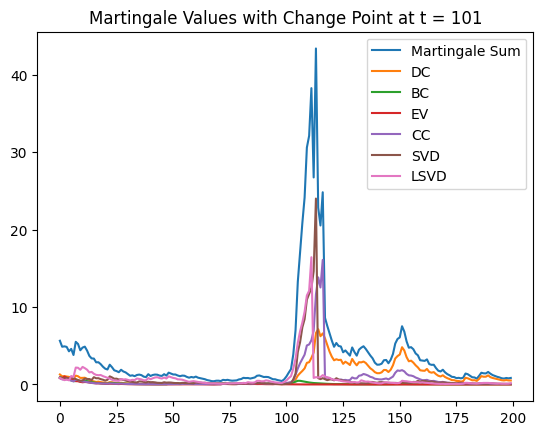

In [29]:
#Observing the martingale values with change point at 101 time instant

plt.plot(Msum)
plt.plot(Mdc['martingales'])
plt.plot(Mbc['martingales'])
plt.plot(Mev['martingales'])
plt.plot(Mcc['martingales'])
plt.plot(Msvd['martingales'])
plt.plot(Mlsvd['martingales'])
plt.legend(['Martingale Sum', 'DC', 'BC', 'EV', 'CC', 'SVD', 'LSVD'])
plt.title('Martingale Values with Change Point at t = 101')
plt.show()

# Demonstration to observe behaviour of SHAPely values

In [30]:
Mdc = Obj.martingaleTest(dc, detect=False)
Mbc = Obj.martingaleTest(bc, detect=False)
Mev = Obj.martingaleTest(ev, detect=False)
Mcc = Obj.martingaleTest(cc, detect=False)
Msvd = Obj.martingaleTest(svd, detect=False)
Mlsvd = Obj.martingaleTest(lsvd, detect=False)
Msum = Mdc['martingales'] + Mbc['martingales'] + Mev['martingales'] + Mcc['martingales'] + Msvd['martingales'] + Mlsvd['martingales']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.28829429967188747, 0.7043651546061351, 0.03516591021243339, 0.33834749014575993, 0.49898930055830276, 0.5393892505746471, 0.9084266651106224, 0.06813041932433427, 0.46151175198857275, 0.9234396272753262, 0.29999573980581934, 0.2517541508481274, 0.9046210677929726, 0.9711387637645564, 0.8968525759763939, 0.6493365808177687, 0.9944615726418305, 0.16994148587892915, 0.9307303097407276, 0.7169785645982246, 0.5073289821865088, 0.7461406199875937, 0.06742305728870276, 0.4932708779308625, 0.883229772424894, 0.69219478713843, 0.40357219536347455, 0.14910970665320025, 0.9273793039426519, 0.7153047255114217, 0.9038314942888079, 0.9003691671920614, 0.30162933144131077, 0.5895512396871624, 0.7552596370139146, 0.5833774987721201, 0.49292378961104605, 0.5729261316454767, 0.8074623783974177, 0.09742410007406861, 0.8733194081996806, 0.5342873729954014, 0.7892737723620196, 0.4070848711169505, 0.32987618732610396, 0.16446942712194978, 0.37124443020938114, 0.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.04424751607871957, 0.9530040763070029, 0.07076270492633079, 0.4626233453723936, 0.8511742042654715, 0.9408556106162053, 0.8906842244973044, 0.36438650930088096, 0.24141822654382572, 0.9149161640270114, 0.1340671617290399, 0.2854755515473297, 0.4559063923588545, 0.8179118868162304, 0.9782573317513668, 0.5687550597574476, 0.9440812254943526, 0.5930552921085899, 0.6855512659176108, 0.9823889843557568, 0.5683846839223181, 0.7712977345937552, 0.005851781971567694, 0.2994382978035144, 0.8825026886866365, 0.8721959718824027, 0.5060861569543119, 0.2662410710210951, 0.7151856020055345, 0.7190000585144898, 0.6825846001610355, 0.6207540278712412, 0.8236558126789798, 0.5049963129402798, 0.4794361141694715, 0.8524938070452728, 0.4945745976499829, 0.5015745153405669, 0.972698290976097, 0.35019413892243445, 0.8022149707578456, 0.3173927017327607, 0.42178861733910233, 0.6416086571840499, 0.5517964659661669, 0.24013963923372975, 0.9359105608494528, 0.383342

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.42456103582474813, 0.3769524605050043, 0.2078892836623234, 0.655575075322832, 0.648594418859181, 0.7863396817745163, 0.9190598216702642, 0.8059140103873462, 0.3483372462854906, 0.9981066006204525, 0.7325457495064264, 0.1676402787119786, 0.41184239196145145, 0.9635390294481115, 0.9465608175808439, 0.5537010098415173, 0.9980521666095936, 0.3261552898967105, 0.8782415375369886, 0.6906188009175731, 0.5404879793935436, 0.7630233957482897, 0.11594479931690904, 0.5906339248616409, 0.7448598678015991, 0.7442574000417796, 0.6497382842714676, 0.10616855916372374, 0.9765436807243936, 0.9122831433224604, 0.9403086866396871, 0.8263415371448608, 0.4509130297069748, 0.6806713412963996, 0.7652458798661939, 0.6221278003060453, 0.2524755176961525, 0.5693018945907372, 0.6612843153278132, 0.5919392237378216, 0.8255611310011007, 0.5940229816349399, 0.6846338862297198, 0.4976467881005496, 0.35184479353612996, 0.11820626942632786, 0.510414795716399, 0.77094126568

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.308694078163788, 0.9124097601324843, 0.12666051117145527, 0.33688308830650426, 0.5549720778050935, 0.7948271834710227, 0.9910945546497559, 0.09713459611501507, 0.5166373076466869, 0.9112608758331125, 0.839355910339206, 0.3986754017694682, 0.8417080546086075, 0.9937379054419179, 0.9251327098323343, 0.6777829085851286, 0.9829325031751078, 0.22083779784425156, 0.9243146476751072, 0.7925617795037132, 0.2017715546739252, 0.8138191949272617, 0.07062572241236027, 0.46121796173244006, 0.8843868855389654, 0.6652256571161419, 0.23424187563047016, 0.1505469610491334, 0.8953601364659534, 0.7332378881220908, 0.9220163362747419, 0.9179944112514489, 0.24293075751488993, 0.5634435366961266, 0.734042941043493, 0.5502541310229555, 0.5654569168940644, 0.598161200539313, 0.9074278015665388, 0.07317200195322601, 0.8053245168016595, 0.6823983355816887, 0.7988697050285855, 0.3978218150689402, 0.25640869423973195, 0.14606422500797914, 0.3231065348570255, 0.7292334

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.676532973023157, 0.44379648208200273, 0.9716604463778481, 0.182380135768517, 0.7471533547326774, 0.032289917039908654, 0.9271626346504132, 0.5606840431390132, 0.9337990689658702, 0.7190893494730966, 0.20703030827069233, 0.019559220159809043, 0.5150243360193345, 0.3461044519629202, 0.8343695041082173, 0.056616876657108905, 0.7112779368376145, 0.27837274385685634, 0.7029237420347249, 0.5739450704873323, 0.8993430579398689, 0.1228419508821015, 0.0038528390663303243, 0.6320204897000988, 0.9336489934733767, 0.29984943393233127, 0.7325178561155539, 0.26547225316554196, 0.5909544630674646, 0.7177925311242556, 0.8174901944547311, 0.9288715602989619, 0.3186888565053669, 0.7561457514945082, 0.412985288881979, 0.10297614565642083, 0.48905992817209043, 0.7521716524678945, 0.754666859782082, 0.09674648046185663, 0.4787425811341788, 0.4062017236960629, 0.7361956265319759, 0.9943676205097133, 0.6913349661002809, 0.36868068612051963, 0.03345447913634718, 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.5627908844019541, 0.5872392758324141, 0.8602317755910233, 0.11497828136266236, 0.7345818718320307, 0.07042341173972123, 0.666215855052571, 0.10067398572333293, 0.3886258630127363, 0.6693196606265113, 0.18024231875004962, 0.47464654982012305, 0.5789997880546424, 0.8618836639727289, 0.22439812253961694, 0.7258368703792437, 0.5609740571562383, 0.3512378998497694, 0.30412319103727997, 0.6406684054522727, 0.5660390991860395, 0.6138579095865478, 0.6467448350500373, 0.9958505400560127, 0.8027931719277126, 0.41063284931048305, 0.3886575828044832, 0.047256420118563805, 0.4945018129473675, 0.2379499439778886, 0.6103813594235674, 0.6851699486580106, 0.11326599499585044, 0.4841366877636446, 0.0647302029301643, 0.47292175317241764, 0.5172225602253336, 0.9062480062498526, 0.22717567526437152, 0.07462593877361633, 0.8257158637338166, 0.15611715522048794, 0.21556344086958093, 0.2879571965901167, 0.5625865777650577, 0.5737246015650851, 0.11874472225771136, 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

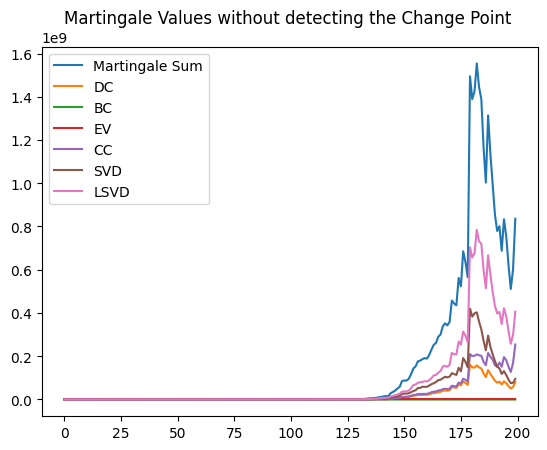

In [31]:
#They are supposed to increase exponentially

plt.plot(Msum)
plt.plot(Mdc['martingales'])
plt.plot(Mbc['martingales'])
plt.plot(Mev['martingales'])
plt.plot(Mcc['martingales'])
plt.plot(Msvd['martingales'])
plt.plot(Mlsvd['martingales'])
plt.legend(['Martingale Sum', 'DC', 'BC', 'EV', 'CC', 'SVD', 'LSVD'])
plt.title('Martingale Values without detecting the Change Point ')
plt.show()

In [32]:
X = np.vstack((Mdc['martingales'], Mbc['martingales'], Mev['martingales'], Mcc['martingales'], Msvd['martingales'], Mlsvd['martingales']))
y = y = [20 if i>=101 else 1 for i in range(200) ]
X = X.transpose()
X.shape, len(y)

((200, 6), 200)

In [33]:
# Our Custom Threshold model
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define the custom model
class CustomThresholdModel(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5):
        """
        Initialize the model with a threshold.
        :param threshold: The threshold value for the sum of the input features.
        """
        self.threshold = threshold

    def fit(self, X, y=None):
        """
        Fit the model. This method doesn't do anything as our model doesn't require training.
        :param X: Input features.
        :param y: True labels (optional).
        :return: self
        """
        return self

    def predict(self, X):
        """
        Predict the labels based on the input features.
        :param X: Input features.
        :return: Predicted labels (1 or 0).
        """
        # Calculate the sum of input features
        sums = np.sum(X, axis=1)
        # Apply the threshold
        return (sums > self.threshold).astype(int)

# Step 2: Get the data ready
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create and use the model
explanation_model = CustomThresholdModel(threshold=20)
explanation_model.fit(X_train, y_train)  # Fit the model (though fitting is not necessary in this case)
predictions = explanation_model.predict(X_test)


In [34]:
explainer = shap.KernelExplainer(explanation_model.predict, X)
shap_values = explainer.shap_values(X)

  0%|          | 0/200 [00:00<?, ?it/s]

In [35]:
import matplotlib.pyplot as plt

def plot_results(martingale_sum, Mdc, Mbc, Mev, Mcc, Msvd, Mlsvd, shap_values, a, b):
  plt.figure(figsize=(10, 10))

  plt.subplot(2,1,1)
  x_range = range(a,b)
  plt.plot(x_range, Msum[a:b], color='cyan')
  plt.plot(x_range, Mdc['martingales'][a:b], color='orange')
  plt.plot(x_range, Mbc['martingales'][a:b], color='green')
  plt.plot(x_range, Mev['martingales'][a:b], color='red')
  plt.plot(x_range, Mcc['martingales'][a:b], color='purple')
  plt.plot(x_range, Msvd['martingales'][a:b], color='brown')
  plt.plot(x_range, Mlsvd['martingales'][a:b], color='pink')

  plt.legend(['Feature Sum', 'Degree Centrality', 'Betweenness Centrality', 'Eigen Vector Centrality', 'Closeness Centrality', 'Singular Value Decomposition', 'Laplacian SVD'])
  plt.title('Martingale measures')

  plt.subplot(2,1,2)
  plt.plot(x_range, shap_values[:,0][a:b], color='orange')
  plt.plot(x_range, shap_values[:,1][a:b], color='green')
  plt.plot(x_range, shap_values[:,2][a:b], color='red')
  plt.plot(x_range, shap_values[:,3][a:b], color='purple')
  plt.plot(x_range, shap_values[:,4][a:b], color='brown')
  plt.plot(x_range, shap_values[:,5][a:b], color='pink')
  # plt.axvline(x=108, color='r', linestyle='--')
  plt.legend(['Degree Centrality', 'Betweenness Centrality', 'Eigen Vector Centrality', 'Closeness Centrality', 'Singular Value Decomposition', 'Laplacian SVD'])
  plt.title('SHAP values with Kernel explanation on martingale custom threshold model')

  # Set x-axis ticks and labels
  # plt.xticks(x_range, x_range)

  # Adjust layout and display the plot
  plt.tight_layout()
  plt.show()


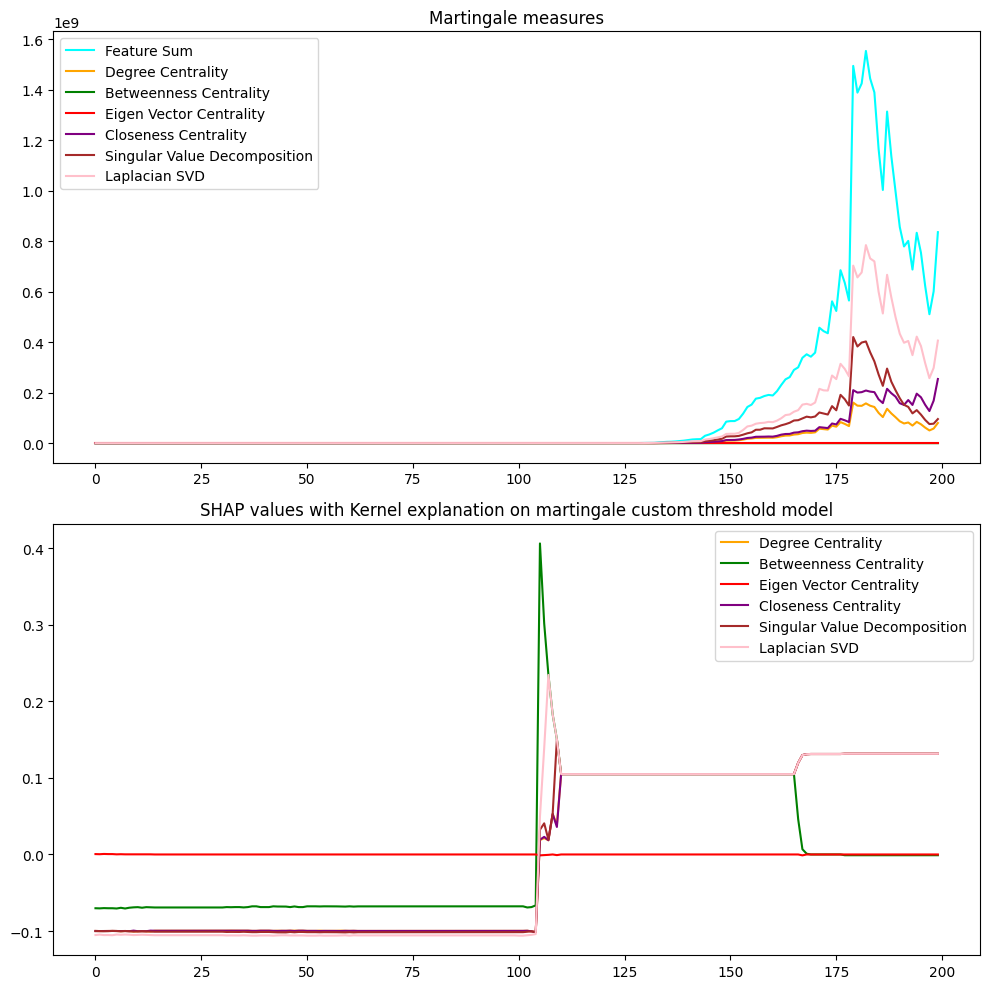

In [36]:
plot_results(Msum, Mdc, Mbc, Mev, Mcc, Msvd, Mlsvd, shap_values, 0, 200)

# Working with real world data

The MIT data is taken from :

http://realitycommons.media.mit.edu/index.html

In [37]:
from google.colab import drive
drive.mount('/content/drive')
raw_data = pd.read_csv('/content/drive/MyDrive/Thesis2/SocialEvolution/Proximity.csv')
raw_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,user.id,remote.user.id.if.known,time,prob2
0,58,42,2007-09-05 14:02:11,0.034
1,58,49,2007-09-05 14:02:11,0.000
2,58,54,2007-09-05 14:02:11,NaN
3,58,57,2007-09-05 14:02:11,0.233
4,58,74,2007-09-05 14:02:11,NaN


# Preprocess the data and convert it into the graphs and dates

In [38]:
raw_data.dropna(inplace=True, subset=['prob2'])
raw_data = raw_data[raw_data.prob2 > 0.3]
raw_data['time'] = pd.to_datetime(raw_data['time'])
raw_data['date'] = raw_data.time.dt.date
raw_data.drop(['time', 'prob2'], axis = 1, inplace=True)
raw_data.drop_duplicates(inplace=True, keep='first')

raw_data.reset_index(drop=True, inplace=True)
filtered_data = raw_data

filtered_data.to_csv('filtered_data.csv')

filtered_dates = raw_data.drop_duplicates(subset=['date'], keep='first')
filtered_dates.reset_index(drop=True, inplace=True)
filtered_dates.index = filtered_dates.index + 1
filtered_dates = filtered_dates.date

filtered_dates.to_csv('filtered_dates.csv')

In [39]:
filtered_data

,user.id,remote.user.id.if.known,date
0,58,70,2007-09-05
1,5,30,2008-01-09
2,5,42,2008-01-09
3,5,47,2008-01-09
4,35,51,2008-01-21
...,...,...,...
24421,67,22,2009-06-24
24422,30,42,2009-06-24
24423,67,22,2009-06-25
24424,64,44,2009-07-05


In [40]:
filtered_dates

,date
1,2007-09-05
2,2008-01-09
3,2008-01-21
4,2008-01-23
5,2008-01-29
...,...
285,2009-06-23
286,2009-06-24
287,2009-06-25
288,2009-07-05


#Creating graphs out of data

In [41]:
# filtered_data['user.id'].max(), filtered_data['remote.user.id.if.known'].min()
result_graphs = []
current_date = None
current_group = []

for _, row in filtered_data.iterrows():
    date = row['date']
    edge = (row['user.id'], row['remote.user.id.if.known'])

    if date != current_date:
        # Start a new group
        if current_group:
          result_graphs.append(current_group)
        current_group = [edge]
        current_date = date
    else:
        current_group.append(edge)

# Append the last group
if current_group:
    result_graphs.append(current_group)

# Display the list of lists of tuples
print(result_graphs)


graphs = []
for group in result_graphs:
    G = nx.Graph()
    G.add_nodes_from(range(1,80))
    for edge in group:
        G.add_edge(*edge)
    graphs.append(G)



[[(58, 70)], [(5, 30), (5, 42), (5, 47)], [(35, 51), (35, 60)], [(68, 2), (68, 15), (68, 60), (16, 11)], [(34, 28)], [(34, 42), (28, 14), (28, 34), (28, 47), (28, 5), (28, 69), (28, 59), (28, 8), (28, 57)], [(18, 48)], [(29, 69), (29, 32)], [(47, 28), (47, 5), (47, 36), (47, 30), (47, 55), (47, 34), (47, 59), (47, 20), (47, 42), (47, 66), (47, 14)], [(69, 15), (69, 35), (69, 32)], [(69, 15), (69, 35)], [(69, 15), (69, 35), (69, 72), (69, 65), (69, 79), (69, 18), (69, 32)], [(69, 32), (69, 72), (69, 79), (69, 35), (69, 15), (69, 29), (69, 67), (69, 19)], [(22, 32)], [(15, 60)], [(36, 5), (36, 47), (36, 69), (36, 30), (36, 46)], [(71, 62), (71, 72)], [(70, 1), (70, 44), (70, 6), (70, 57), (70, 61)], [(24, 57)], [(24, 57)], [(1, 14), (1, 27), (1, 70), (61, 14), (61, 27), (61, 70), (1, 71), (61, 5)], [(24, 57), (69, 60), (69, 32), (69, 29), (69, 65), (69, 67), (69, 19), (27, 70), (27, 1), (30, 5), (30, 36), (65, 47), (65, 60), (65, 69), (59, 30), (59, 47), (64, 47), (64, 69), (67, 32), (67

In [42]:
#Just making sure we didn't miss out any edges

list_lengths = [len(inner_list) for inner_list in result_graphs]

sum(list_lengths) == len(filtered_data),  #number of edges should be 24426 and number of graphs should be 289

(True,)

In [43]:
#our graph matrices

adj_matrices = []

for graph in graphs:
  adj_matrices.append(nx.to_numpy_array(graph, dtype=int))

len(adj_matrices)

289

# Do the same test as previous but with MIT data

In [45]:
Obj = ChangePointDetection(adj_matrices)
dc = Obj.deg_centrality(adj_matrices)
bc = Obj.betweenness_centrality(adj_matrices)
ev = Obj.eigenvector_centrality(adj_matrices)
cc = Obj.closeness_centrality(adj_matrices)
svd = Obj.SVDEmbedding(adj_matrices)
lsvd = Obj.LSVDembedding(adj_matrices)
print(f'Degree Centrality Shapes:       {len(dc), len(dc[1])}')
print(f'Betweenness Centrality Shapes:  {len(bc), len(bc[1])}')
print(f'Eigen Vec Centrality Shapes:    {len(ev), len(ev[1])}')
print(f'Closeness Centrality Shapes:    {len(cc), len(ev[1])}')
print(f'SVD Shapes:                     {len(svd), len(svd[1])}')
print(f'LSVD Shapes:                    {len(lsvd), len(lsvd[1])}')

Degree Centrality Shapes:       (289, 79)
Betweenness Centrality Shapes:  (289, 79)
Eigen Vec Centrality Shapes:    (289, 79)
Closeness Centrality Shapes:    (289, 79)
SVD Shapes:                     (289, 158)
LSVD Shapes:                    (289, 79)


# Events to observe:
 1. Christmas and New Year event on Dec 25th and Jan 1st

 Graph instants 81-141 (Dec 1st, 2008 - Jan 31st, 2009)

 2. Columbus Day on Oct 13th (Graph instant 33)

 Graph instants 1- 60 (Jan 9th - Nov 5th)

 3. Thanksgiving on Nov 26th and 27th

 graph instants 65 - 100 (Nov 14th - Dec 20th)

In [118]:
NewYear = {
    'dc_NewYear': dc[81:141],
    'bc_NewYear': bc[81:141],
    'ev_NewYear': ev[81:141],
    'cc_NewYear': cc[81:141],
    'svd_NewYear': svd[81:141],
    'lsvd_NewYear': lsvd[81:141]
}

ColumbusDay = {
    'dc_ColumbusDay': dc[1:60],
    'bc_ColumbusDay': bc[1:60],
    'ev_ColumbusDay': ev[1:60],
    'cc_ColumbusDay': cc[1:60],
    'svd_ColumbusDay': svd[1:60],
    'lsvd_ColumbusDay': lsvd[1:60]
}

Thanksgiving = {
    'dc_Thanksgiving': dc[230:300],
    'bc_Thanksgiving': bc[230:300],
    'ev_Thanksgiving': ev[230:300],
    'cc_Thanksgiving': cc[230:300],
    'svd_Thanksgiving': svd[230:300],
    'lsvd_Thanksgiving': lsvd[230:300]
}

# dc_NewYear = dc[81:141]
# bc_NewYear = bc[81:141]
# ev_NewYear = ev[81:141]
# cc_NewYear = cc[81:141]
# svd_NewYear = svd[81:141]
# lsvd_NewYear = lsvd[81:141]


# Observing New Year event

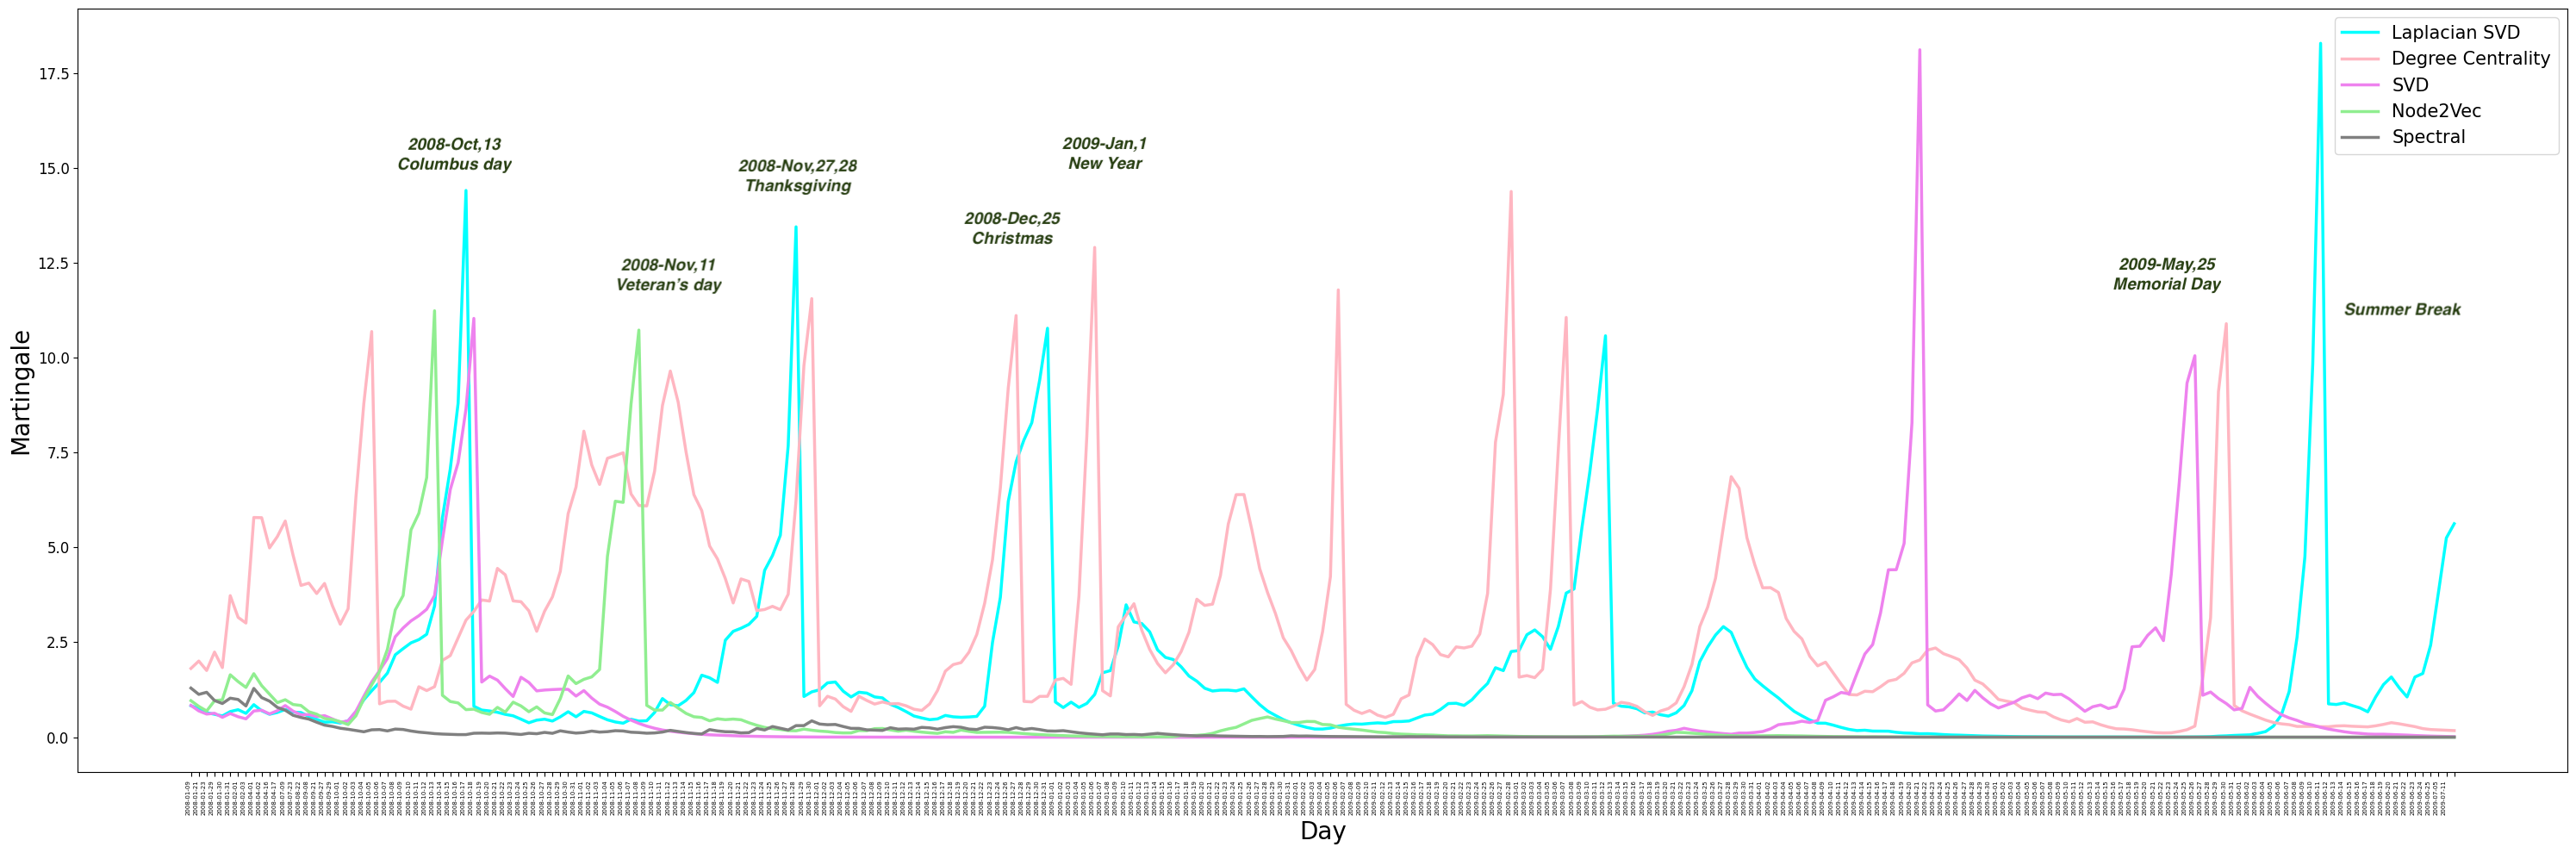

In [49]:
Mdc_ny = Obj.martingaleTest(NewYear['dc_NewYear'], detect=False)
Mbc_ny = Obj.martingaleTest(NewYear['bc_NewYear'], detect=False)
Mev_ny = Obj.martingaleTest(NewYear['ev_NewYear'], detect=False)
Mcc_ny = Obj.martingaleTest(NewYear['cc_NewYear'], detect=False)
Msvd_ny = Obj.martingaleTest(NewYear['svd_NewYear'], detect=False)
Mlsvd_ny = Obj.martingaleTest(NewYear['lsvd_NewYear'], detect=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.748974758041696, 0.5205872088872163, 0.6902990704908091, 0.6266854413175477, 0.05371788566085602, 0.48200671512425003, 0.7589616587438515, 0.18857045652710874, 0.41600083795270604, 0.3663609136212278, 0.4255411209074513, 0.5904052897859302, 0.32063369769273903, 0.05047840083811218, 0.0472738836999395, 0.04717752546811298, 0.21076219166448187, 0.2255713317243553, 0.06854296027798006, 0.05637763329120019, 0.08767668442984694, 0.054649889085769204, 0.10978384627395248, 0.04188075748947276, 0.13793303257337677, 0.2724101169207022, 0.40214268553511945, 0.4118715463333592, 0.4403797656459236, 0.44515516910986375, 0.5112215457264522, 0.5543837004505656, 0.43842956931705057, 0.39243610824838493, 0.23137101000290933, 0.10775894574335215, 0.3453102164297396, 0.07069907213500824, 0.0014364015993868352, 0.08269424373042314, 0.05968192747920518, 0.10817615332492708, 0.252742613099844, 0.11140233140828334, 0.04985230791990782, 0.24851165371420395, 0.1804

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.8594893643499908, 0.5188312744474388, 0.8670864968385374, 0.7079501341728365, 0.36473910629016554, 0.6716087965555037, 0.014730221693082737, 0.3522171208174986, 0.4075513428846815, 0.22537047115488082, 0.4087553301525569, 0.05041187840550438, 0.5395514797657857, 0.8752109492728009, 0.012725118428942505, 0.9237505453230528, 0.36064615168676106, 0.24689897813575368, 0.566409918045337, 0.5666418652327149, 0.49060690449058264, 0.45455181876858153, 0.5007129002328764, 0.5701718163122353, 0.5091851146343429, 0.5916807425360506, 0.49133986509241756, 0.41699854328984703, 0.6428036392613133, 0.7180933233591348, 0.7251070060065115, 0.7060922252066459, 0.46565554406929766, 0.7084507660557723, 0.7783187239323698, 0.20431821608767606, 0.7549150322934038, 0.19188120962657038, 0.14159340819576935, 0.20008568834123763, 0.05978452960354819, 0.14340159551364384, 0.019443318906777418, 0.30238171109270173, 0.3279180650659907, 0.4493797732580978, 0.082837686680

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.08984008111173081, 0.9184858556626754, 0.4699453344451692, 0.6807248943755564, 0.4193620288904376, 0.7646448274297705, 0.3443903802887543, 0.10024026561897938, 0.5947608374863173, 0.9938435248573791, 0.05548599074388214, 0.4584668506888834, 0.41400079185474187, 0.395583833574449, 0.7978068833056857, 0.37491222709721334, 0.38627915341047947, 0.3984416749640682, 0.22450399579501712, 0.10167482421572349, 0.006531663601345082, 0.28156234575275507, 0.2637392921178837, 0.022061025708640783, 0.005639132280161791, 0.10215126556298951, 0.0987430625009595, 0.2119184513294634, 0.13397124916541386, 0.13333527347592847, 0.13323066296209987, 0.31742315265663673, 0.07329197510324369, 0.14223902334437152, 0.2393762853146033, 0.054391946471156145, 0.08166717632735677, 0.8944410188634822, 0.4898284600399292, 0.5786992691316206, 0.8975652453153381, 0.7592538905134013, 0.9825429536577542, 0.7132311893285984, 0.9684284493207943, 0.4715600442005228, 0.0855994257

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.19187219474177575, 0.5448034592683069, 0.4425775339885305, 0.6061895875079812, 0.06555286866463228, 0.7870990110756284, 0.11990941389213958, 0.2214343028366037, 0.3552662419936212, 0.13990439255881718, 0.812104851645428, 0.34785288276283205, 0.7197272607659285, 0.3021856505693794, 0.029168935894343974, 0.16302277646973617, 0.40707731983114, 0.32210306437949004, 0.17443656609253663, 0.3306660177703379, 0.13501934079627995, 0.09325876497289315, 0.18128159947820824, 0.17315527359861416, 0.31752590991708823, 0.35234544525137895, 0.4429784009938762, 0.36904610270402466, 0.45924632109796076, 0.5848992561432952, 0.5790041172044545, 0.4683629396404557, 0.4181254756130274, 0.6298774178941254, 0.7824365711909844, 0.23372458460303294, 0.8134826873669205, 0.05868398117531239, 0.012340851610600731, 0.13206738562751136, 0.11183693208281745, 0.1464686807126208, 0.047011629237626786, 0.27374172745638536, 0.1074272177840275, 0.6857735646654222, 0.0970014900

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.5777174471590398, 0.6696065462561656, 0.6025377731268632, 0.22255804643222626, 0.30617723599942065, 0.6841712086806958, 0.34698545885269455, 0.02171460739831879, 0.8599295678414488, 0.6945942537295317, 0.46022963158962066, 0.2649533670912447, 0.13029563384828086, 0.42397169212818525, 0.18716262329504788, 0.041908493236597746, 0.4151821797041839, 0.4159529420330785, 0.9642689151216681, 0.8816219164436847, 0.9977206547434759, 0.9866399521986927, 0.9230775798751216, 0.9552833081323873, 0.9744397464081979, 0.8393920512323946, 0.8376952643288886, 0.8318352852866935, 0.7740157244823371, 0.6699365552301748, 0.714935481312107, 0.8547531763017875, 0.9857041128960671, 0.5903150753440322, 0.5143639152005918, 0.10327258845404723, 0.44780420838243734, 0.26066338418372115, 0.016174889052373527, 0.20211880044402494, 0.11462379869550304, 0.1709640572010822, 0.5425231785499228, 0.21376957577805067, 0.08493777853747181, 0.2825787818762041, 0.2739484240904626

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.5464585635264656, 0.06116148115320591, 0.14138708614468584, 0.935463267330958, 0.14458525452569818, 0.6566235902961164, 0.6774892791487898, 0.4963902078722222, 0.26078424020358715, 0.7694843512741004, 0.5873892171716386, 0.8614910836452708, 0.7660064769872288, 0.21687873752479092, 0.12646568338214445, 0.009217327209114168, 0.9734507996089521, 0.44845950558790143, 0.08407911991160706, 0.06300586507039399, 0.021078268327030164, 0.01981087071251625, 0.07537498069568063, 0.1226894068774707, 0.12616706338673744, 0.20330212866898972, 0.22470216765629691, 0.19211358177085844, 0.18372081050383457, 0.2815243538191992, 0.25036089154568136, 0.14444509556985502, 0.18808317874702288, 0.7521964150345507, 0.8934551933579493, 0.524309118228845, 0.8946929587648321, 0.4999906106478837, 0.010590867987133006, 0.5886082679745669, 0.35935731120337316, 0.45232580537322326, 0.6605535017007595, 0.3667155471012189, 0.35527004993321476, 0.4934557596399888, 0.49703000

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [59]:
Msum_ny = Mdc_ny['martingales']+Mbc_ny['martingales']+Mev_ny['martingales']+Mcc_ny['martingales']+Msvd_ny['martingales'] + Mlsvd_ny['martingales']

In [91]:
X_ny = np.vstack((Mdc_ny['martingales'], Mbc_ny['martingales'], Mev_ny['martingales'], Mcc_ny['martingales'], Msvd_ny['martingales'], Mlsvd_ny['martingales']))
X_ny = X_ny.transpose()
X_ny.shape

(60, 6)

In [92]:
explainer2 = shap.KernelExplainer(explanation_model.predict, X_ny)
shap_values2 = explainer2.shap_values(X_ny)

  0%|          | 0/60 [00:00<?, ?it/s]

<ipython-input-93-1b3126daa890>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=dates_NewYear, rotation=90, ha='right')
<ipython-input-93-1b3126daa890>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=dates_NewYear, rotation=90, ha='right')


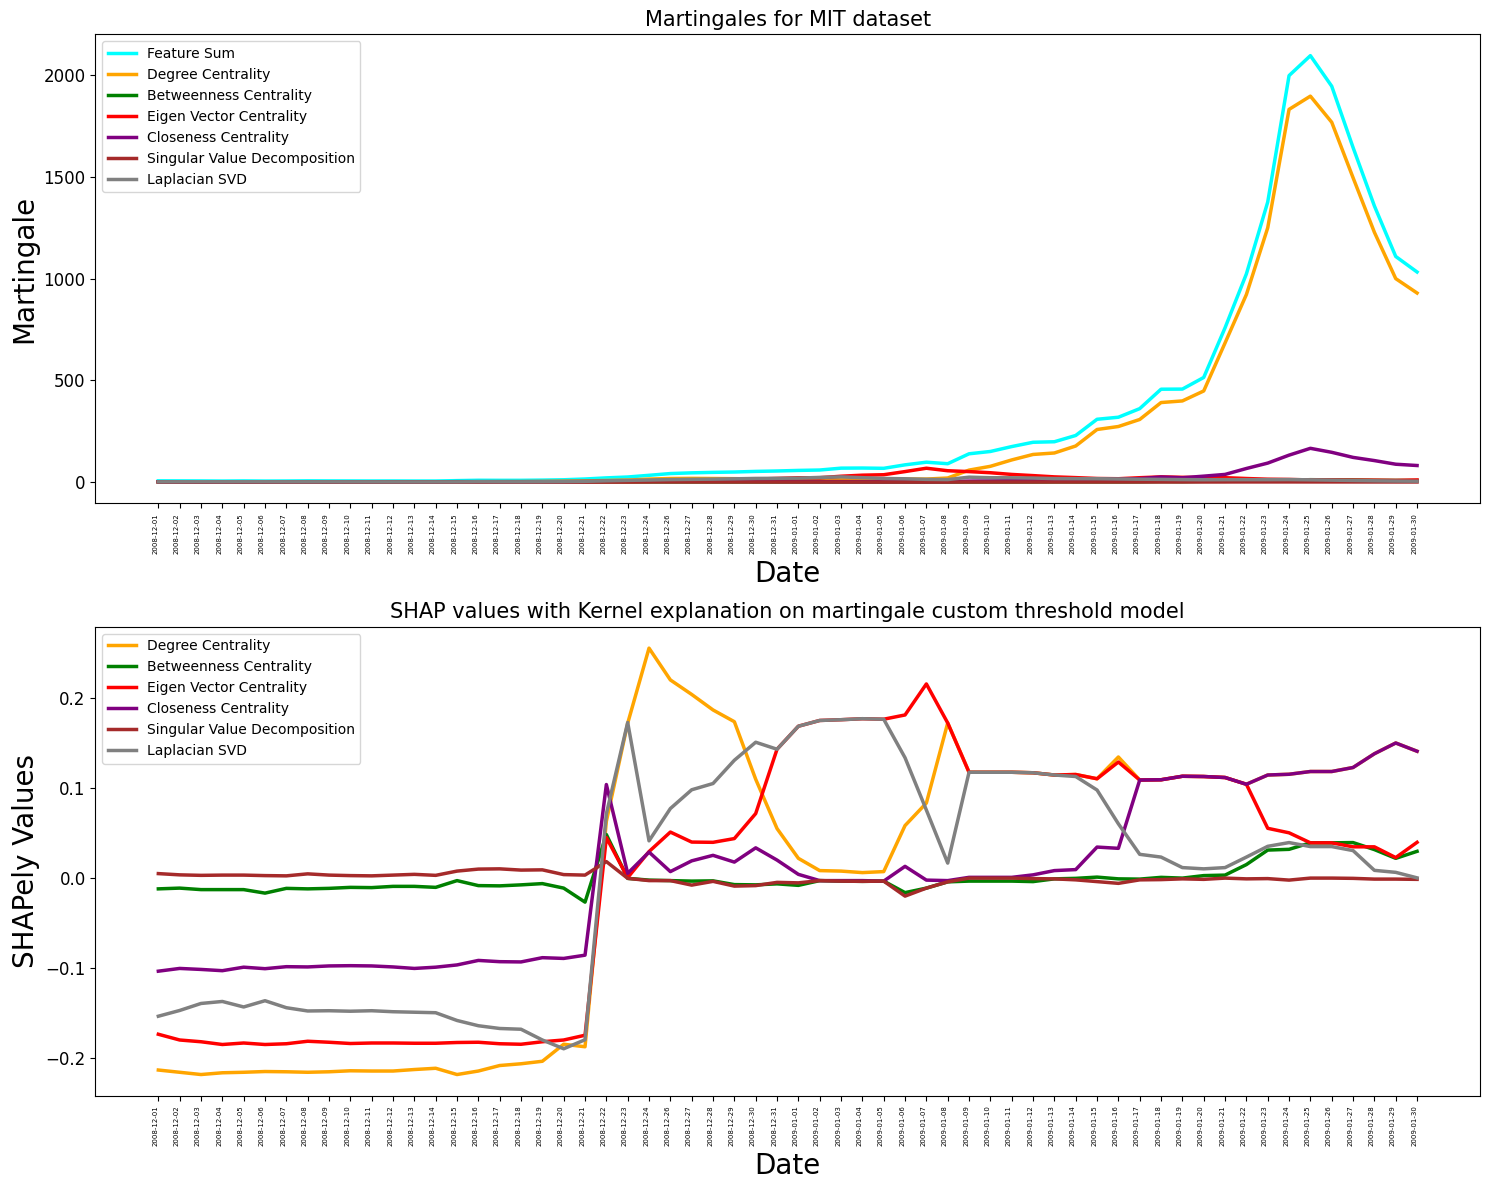

In [93]:
dates_NewYear = filtered_dates.astype(str)[81:141]
plt.figure(figsize=(15, 12))

plt.subplot(2,1,1)

plt.xlabel('Date', fontsize = 20)
plt.ylabel('Martingale', fontsize = 20)
plt.legend(fontsize = 15)
plt.title('Martingales for MIT dataset', fontsize = 15)

ax = sns.lineplot(y = Msum_ny, x= dates_NewYear, color = 'cyan', label='Feature Sum', linewidth = 2.5)

sns.lineplot(y = Mdc_ny['martingales'], x = dates_NewYear, color = 'orange', label='Degree Centrality', linewidth = 2.5)
sns.lineplot(y = Mbc_ny['martingales'], x = dates_NewYear, color = 'green', label='Betweenness Centrality', linewidth = 2.5)
sns.lineplot(y = Mev_ny['martingales'], x = dates_NewYear, color = 'red', label='Eigen Vector Centrality', linewidth = 2.5)
sns.lineplot(y = Mcc_ny['martingales'], x = dates_NewYear, color = 'purple', label='Closeness Centrality', linewidth = 2.5)
sns.lineplot(y = Msvd_ny['martingales'], x = dates_NewYear, color = 'brown', label='Singular Value Decomposition', linewidth = 2.5)
sns.lineplot(y = Mlsvd_ny['martingales'], x = dates_NewYear, color = 'gray', label='Laplacian SVD', linewidth = 2.5)


ax.set_xticklabels(labels=dates_NewYear, rotation=90, ha='right')
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=12)


plt.subplot(2,1,2)

plt.xlabel('Date', fontsize = 20)
plt.ylabel('SHAPely Values', fontsize = 20)
plt.legend(fontsize = 15)
plt.title('SHAP values with Kernel explanation on martingale custom threshold model', fontsize = 15)


ax = sns.lineplot(y = shap_values2[:,0], x = dates_NewYear, color = 'orange', label='Degree Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values2[:,1], x = dates_NewYear, color = 'green', label='Betweenness Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values2[:,2], x = dates_NewYear, color = 'red', label='Eigen Vector Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values2[:,3], x = dates_NewYear, color = 'purple', label='Closeness Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values2[:,4], x = dates_NewYear, color = 'brown', label='Singular Value Decomposition', linewidth = 2.5)
sns.lineplot(y = shap_values2[:,5], x = dates_NewYear, color = 'gray', label='Laplacian SVD', linewidth = 2.5)


ax.set_xticklabels(labels=dates_NewYear, rotation=90, ha='right')
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=12)

# plt.title('Martingales for MIT dataset', fontsize = 20)

plt.tight_layout()
plt.show()

# Observing Columbus Day

In [68]:
Mdc_cd = Obj.martingaleTest(ColumbusDay['dc_ColumbusDay'], detect=False)
Mbc_cd = Obj.martingaleTest(ColumbusDay['bc_ColumbusDay'], detect=False)
Mev_cd = Obj.martingaleTest(ColumbusDay['ev_ColumbusDay'], detect=False)
Mcc_cd = Obj.martingaleTest(ColumbusDay['cc_ColumbusDay'], detect=False)
Msvd_cd = Obj.martingaleTest(ColumbusDay['svd_ColumbusDay'], detect=False)
Mlsvd_cd = Obj.martingaleTest(ColumbusDay['lsvd_ColumbusDay'], detect=False)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.885780267639093, 0.4431917506142983, 0.3428459878038193, 0.806880610182062, 0.15845087166765218, 0.7763576135983251, 0.5083534251718307, 0.08044730628764092, 0.4030848281864091, 0.7002136268804151, 0.24272213044806043, 0.24345685580521337, 0.6794079395164896, 0.7181185140218209, 0.28569283828900055, 0.470239181157091, 0.2388196347172427, 0.7348082172985909, 0.7192208457073166, 0.16575022992419441, 0.029146406967871713, 0.052666567661189385, 0.09748750749150868, 0.13433309675320987, 0.13803280962143247, 0.09350197224807413, 0.25511881306811984, 0.21518626343305655, 0.27016039482146154, 0.22423279830697238, 0.1315754658985729, 0.011850618024565999, 0.13291191140395758, 0.09513828177263416, 0.028877635431579295, 0.056095223465918886, 0.1257235200014806, 0.16859007860166766, 0.08211720836006894, 0.19880134575856676, 0.28120319243073283, 0.20082839854336595, 0.19748065323527908, 0.41070032714686683, 0.04398364409351151, 0.14093925177957511, 0.02

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.8187659971131619, 0.6710421826315729, 0.5287828855882367, 0.8541866359116957, 0.17435769566516157, 0.763846070072011, 0.5465423024778283, 0.0830374013573638, 0.4957222059247523, 0.7669044286740776, 0.19497905278458838, 0.24300822299776045, 0.6603067717700856, 0.6045675090551137, 0.3111675318512815, 0.508539150442087, 0.23938478011244754, 0.8103186779965232, 0.8137694859401036, 0.34651776445470117, 0.03007409202831595, 0.04380048027643218, 0.07802948529083367, 0.9896671755760548, 0.09726814841642042, 0.12859134992534363, 0.20219499753771095, 0.24425642742830314, 0.12444008371280574, 0.22109430504650884, 0.00863610849449883, 0.042707951961874935, 0.13429435338603207, 0.05511956057943064, 0.15989395181766453, 0.1666413590458003, 0.1067263977990878, 0.034843360590194244, 0.0727535420330082, 0.24017210646558707, 0.047762190918778785, 0.20252813758381494, 0.06123468408775578, 0.39103581518133423, 0.27035143644970683, 0.03616301755391194, 0.086283

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.10988298772414473, 0.29343956115071435, 0.8228825211457265, 0.15759109293236612, 0.8152465339355535, 0.08144831833807965, 0.1971968341381742, 0.7828791011981034, 0.7065391067811659, 0.7931012509426636, 0.7731879783952871, 0.7087230443289249, 0.36239190892775675, 0.5507031284083019, 0.585105651218345, 0.11553529264865048, 0.035849185682829646, 0.17074532624333344, 0.3734330153378175, 0.2662539611184391, 0.7967507202525026, 0.85953632221659, 0.7773250934423651, 0.7555728031463839, 0.9153089285145787, 0.8638464554057946, 0.7908682438885256, 0.8624598696724061, 0.7191402989539152, 0.7439234534050178, 0.7610594368589177, 0.8017810758290402, 0.6953362718046651, 0.7919241974286334, 0.8675491024511042, 0.8656695025151971, 0.4536697110119124, 0.6333703649173854, 0.44496326652101215, 0.4700248550572744, 0.7579753848566856, 0.4508614376627115, 0.5507733569599986, 0.8314414935850702, 0.9667721389714277, 0.7310117671497514, 0.9255040393509751, 0.5014063

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.6867754581596549, 0.48925303009023, 0.4893350822118963, 0.8506561473623895, 0.15052377334608394, 0.6759952304408308, 0.687203651124216, 0.062139708901047114, 0.3594385759526384, 0.7070739779776829, 0.22520093965253565, 0.211682917408716, 0.6330503686990175, 0.7017553754248216, 0.2843371546538997, 0.40324177559751373, 0.26912685998732766, 0.6887385746329602, 0.6407336979466475, 0.23326573166728276, 0.046696009928931935, 0.08024622837088351, 0.11060774556501897, 0.15471055144545967, 0.13798474250698967, 0.10930926368673427, 0.2079894653224619, 0.22240028316892246, 0.19346870587343376, 0.29970478409359563, 0.0900185261065871, 0.002079336171566165, 0.13896197122060885, 0.09536435871537685, 0.04451207678651892, 0.1269339074093305, 0.06967269621173314, 0.16858785205239143, 0.21129541533758434, 0.21275709237653911, 0.18532362391947324, 0.23178896480390196, 0.16105479315596263, 0.27541141162463373, 0.04474600374013092, 0.18186081811375382, 0.073936

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.9565455530431809, 0.07632019728740225, 0.2599572273356145, 0.9643885882952046, 0.08099659621257245, 0.9689576965887278, 0.5963249362771376, 0.11402131049968275, 0.54669858675814, 0.8909835333016508, 0.24661326764589286, 0.20644654099230864, 0.8796371577689137, 0.8587576560894447, 0.3081107844083363, 0.565885703031087, 0.27994530677895035, 0.8450599299253352, 0.8682924616625849, 0.24699374519739697, 0.0015534099574655252, 0.020191606312218887, 0.08896095936336806, 0.1549975058661302, 0.1875410930863161, 0.13530967469454858, 0.2580766916518383, 0.23172348706008974, 0.29624881731853586, 0.2949061301345443, 0.2030628924839399, 0.1234347385333219, 0.2935811140433537, 0.20775060731245443, 0.12107333024714428, 0.09125515129377236, 0.13727079279505458, 0.3292146384306121, 0.09751060471599256, 0.11614183732188214, 0.34788560212840786, 0.14311845373984788, 0.22726776913962882, 0.1835369769022262, 0.011994540409269863, 0.03601580146972801, 0.040447226

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.31897026988218613, 0.24038414111494028, 0.18024230849200584, 0.08193077573893096, 0.0016930816551044448, 0.21165295891927552, 0.6579519383679465, 0.12021110095484186, 0.9747307772276073, 0.6942486734369094, 0.24806307319110948, 0.16921422992560417, 0.34388773050755833, 0.39369174054051465, 0.8009314636425752, 0.5738994420739931, 0.8525105363945716, 0.4923762697459547, 0.5216034907581236, 0.1871778707898322, 0.014647496597812034, 0.05368194828368502, 0.12988337173250178, 0.13989651866872185, 0.1425092753761405, 0.08821553267489876, 0.24039043106458735, 0.22897164006692658, 0.2920328507139356, 0.2586086324989555, 0.12045908268543212, 0.001959617667084204, 0.13439790191712597, 0.09113905745980354, 0.037468164376996224, 0.04382363514779212, 0.12141511874321015, 0.17684051472518522, 0.14003988012171967, 0.1785655891364226, 0.5814472154062545, 0.45054221356816637, 0.47169043330661103, 0.8735551531882013, 0.08456004352032996, 0.23119122682714227, 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [126]:
Msum_cd = Mdc_cd['martingales'] + Mbc_cd['martingales'] + Mev_cd['martingales'] + Mcc_cd['martingales'] + Msvd_cd['martingales'] + Mlsvd_cd['martingales']


In [127]:
Msum_cd.shape

(59,)

In [128]:
X_cd = np.vstack((Mdc_cd['martingales'], Mbc_cd['martingales'], Mev_cd['martingales'], Mcc_cd['martingales'], Msvd_cd['martingales'], Mlsvd_cd['martingales']))
X_cd = X_cd.transpose()
X_cd.shape

(59, 6)

In [129]:
explainer3 = shap.KernelExplainer(explanation_model.predict, X_cd)
shap_values3 = explainer3.shap_values(X_cd)

  0%|          | 0/59 [00:00<?, ?it/s]

<ipython-input-130-5c8a8593da1f>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=dates_ColumbusDay, rotation=90, ha='right')
<ipython-input-130-5c8a8593da1f>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=dates_ColumbusDay, rotation=90, ha='right')


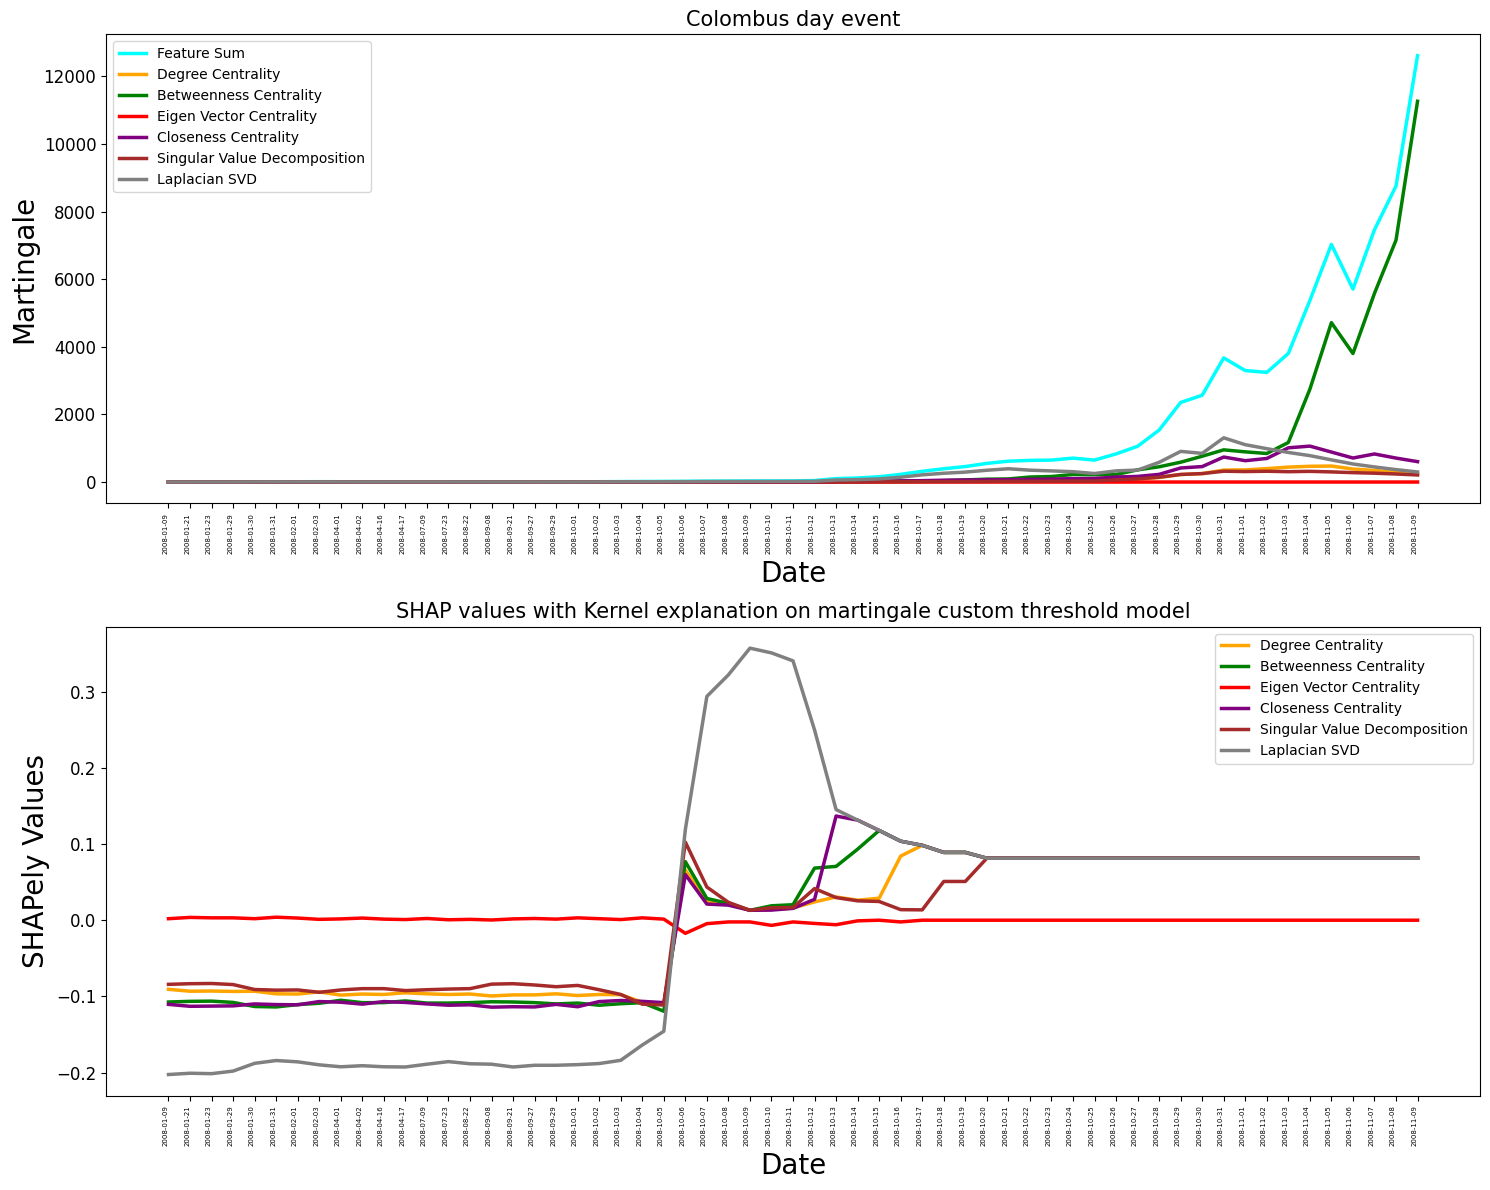

In [130]:
dates_ColumbusDay = filtered_dates.astype(str)[1:60]
plt.figure(figsize=(15, 12))

plt.subplot(2,1,1)

plt.xlabel('Date', fontsize = 20)
plt.ylabel('Martingale', fontsize = 20)
plt.legend(fontsize = 15)
plt.title('Colombus day event', fontsize = 15)

ax = sns.lineplot(y = Msum_cd, x= dates_ColumbusDay, color = 'cyan', label='Feature Sum', linewidth = 2.5)

sns.lineplot(y = Mdc_cd['martingales'], x = dates_ColumbusDay, color = 'orange', label='Degree Centrality', linewidth = 2.5)
sns.lineplot(y = Mbc_cd['martingales'], x = dates_ColumbusDay, color = 'green', label='Betweenness Centrality', linewidth = 2.5)
sns.lineplot(y = Mev_cd['martingales'], x = dates_ColumbusDay, color = 'red', label='Eigen Vector Centrality', linewidth = 2.5)
sns.lineplot(y = Mcc_cd['martingales'], x = dates_ColumbusDay, color = 'purple', label='Closeness Centrality', linewidth = 2.5)
sns.lineplot(y = Msvd_cd['martingales'], x = dates_ColumbusDay, color = 'brown', label='Singular Value Decomposition', linewidth = 2.5)
sns.lineplot(y = Mlsvd_cd['martingales'], x = dates_ColumbusDay, color = 'gray', label='Laplacian SVD', linewidth = 2.5)


ax.set_xticklabels(labels=dates_ColumbusDay, rotation=90, ha='right')
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=12)


plt.subplot(2,1,2)

plt.xlabel('Date', fontsize = 20)
plt.ylabel('SHAPely Values', fontsize = 20)
plt.legend(fontsize = 15)
plt.title('SHAP values with Kernel explanation on martingale custom threshold model', fontsize = 15)


ax = sns.lineplot(y = shap_values3[:,0], x = dates_ColumbusDay, color = 'orange', label='Degree Centrality', linewidth = 2.5)

sns.lineplot(y = shap_values3[:,1], x = dates_ColumbusDay, color = 'green', label='Betweenness Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values3[:,2], x = dates_ColumbusDay, color = 'red', label='Eigen Vector Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values3[:,3], x = dates_ColumbusDay, color = 'purple', label='Closeness Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values3[:,4], x = dates_ColumbusDay, color = 'brown', label='Singular Value Decomposition', linewidth = 2.5)
sns.lineplot(y = shap_values3[:,5], x = dates_ColumbusDay, color = 'gray', label='Laplacian SVD', linewidth = 2.5)


ax.set_xticklabels(labels=dates_ColumbusDay, rotation=90, ha='right')
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=12)

# plt.title('Martingales for MIT dataset', fontsize = 20)

plt.tight_layout()
plt.show()

# Observing Thanksgiving Day

In [119]:
Mdc_tg = Obj.martingaleTest(Thanksgiving['dc_Thanksgiving'], detect=False)
Mbc_tg = Obj.martingaleTest(Thanksgiving['bc_Thanksgiving'], detect=False)
Mev_tg = Obj.martingaleTest(Thanksgiving['ev_Thanksgiving'], detect=False)
Mcc_tg = Obj.martingaleTest(Thanksgiving['cc_Thanksgiving'], detect=False)
Msvd_tg = Obj.martingaleTest(Thanksgiving['svd_Thanksgiving'], detect=False)
Mlsvd_tg = Obj.martingaleTest(Thanksgiving['lsvd_Thanksgiving'], detect=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.7536781333717422, 0.8901767381236799, 0.2479814339065615, 0.6898715974199938, 0.21283165097285375, 0.2783986079291488, 0.6629337449009081, 0.6487265827256341, 0.8909873100810353, 0.005723654758792329, 0.055032089039730156, 0.7934018654836822, 0.08451986581428397, 0.5344620467907434, 0.26931776201751173, 0.45043976454601, 0.11174460377992729, 0.1161613191988396, 0.28627949028058447, 0.13180830527240403, 0.28426596655235714, 0.0741663472977555, 0.005780334424434056, 0.0065432475359990016, 0.03328918982447225, 0.01778155602122957, 0.016281321591459823, 0.0022868523879352653, 0.0053289625382303765, 0.1903647265244483, 0.13864206809081828, 0.2829619659505872, 0.14213549945953807, 0.2607964679028603, 0.12357047439403653, 0.2068720679626788, 0.11576578519594323, 0.1371970261807782, 0.14251520647793, 0.1936053293090247, 0.1283093981113835, 0.2762657122620532, 0.3393416221904974, 0.33157440186039344, 0.35009339890926755, 0.4018837144674998, 0.536128

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.8062002196933209, 0.6975051726842841, 0.20841700767723462, 0.3247646558641327, 0.6257078214819882, 0.12412524482079344, 0.07368141025198863, 0.26114293417126133, 0.5176967230586678, 0.4119943637959295, 0.22058406744378123, 0.26166593425348705, 0.2637003550817642, 0.3640947538774209, 0.07548832044741509, 0.04413746093958226, 0.8719693264636341, 0.7749554203291648, 0.6708593933776422, 0.34919941690578304, 0.2950003335432257, 0.239384300679816, 0.680875628643529, 0.22077761488138226, 0.40156787407129607, 0.12166605680034132, 0.168029529680865, 0.2525601046234805, 0.3414544020822819, 0.2742636086939474, 0.2607097354746723, 0.49710616046381445, 0.44157855727657347, 0.29834914663488216, 0.43843212283815336, 0.44067707612216467, 0.5967923775303661, 0.600069118173514, 0.5243260120402864, 0.7199874020320197, 0.62035456456379, 0.6446231611476493, 0.7661648581099881, 0.624331438264514, 0.7479149100649195, 0.6445679164665952, 0.7312704024476079, 0.6694

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.7490591390979249, 0.36623316084923124, 0.5232361330540862, 0.9050612420032762, 0.697535400871352, 0.5943096911761855, 0.22368321066831395, 0.6618445511527942, 0.9685381393033341, 0.14464955097241927, 0.2719159922317424, 0.22450365967081384, 0.04717214978727206, 0.7915326636566425, 0.18967257301462073, 0.7610775828373849, 0.2606936121172984, 0.10546495630876485, 0.6405138063033696, 0.036650425740081635, 0.03129864457253668, 0.02731543000461227, 0.01836403508391388, 0.037674448434069634, 0.0030891316739036336, 0.01093241770960728, 0.02921269184473123, 0.04704338097728807, 0.07708996704030001, 0.12794572627139908, 0.19799682044907585, 0.19956527556114942, 0.025806770726831435, 0.028278581568827448, 0.044265112282863256, 0.1254789550533614, 0.06941099860112315, 0.014928772111727474, 0.02045776301408165, 0.18178809510242563, 0.10866633249913789, 0.11643184175405236, 0.1520316860511954, 0.028904754959956466, 0.170230124572562, 0.03987486662290975

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.42411452446452624, 0.3114655781737603, 0.2648180141332578, 0.2998439532377994, 0.9537016681853079, 0.07324874247973129, 0.11300580865841665, 0.9339611403015795, 0.7527775284631935, 0.4080803793925584, 0.26661774499939955, 0.3602244656929094, 0.003194282188585418, 0.3939862337123866, 0.3506099441771623, 0.540461748261919, 0.008506431140825348, 0.061292550575199015, 0.28324217679447394, 0.24904215099287086, 0.5965015530261634, 0.10520393415874972, 0.07337857668053445, 0.004597971513525673, 0.028859269930986767, 0.014866100138832938, 0.001218441208600304, 0.08622251616237646, 0.03351046495180283, 0.1394627567418426, 0.2211295169590214, 0.20095143897811585, 0.09373654350105952, 0.09018218680652657, 0.1506494985103644, 0.284540648305308, 0.09641265274876033, 0.10074841707778187, 0.170341040467876, 0.2982249395509402, 0.22609384286242262, 0.25642233470530523, 0.3731295670657981, 0.3389864173349503, 0.3239289294389005, 0.33340009528535386, 0.42824

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.9212712111721573, 0.5373705506215709, 0.6248358225044623, 0.4845735787690808, 0.44290191482231445, 0.8490389390639458, 0.3886451722611574, 0.829045097028662, 0.6863729341052386, 0.17301474786252147, 0.22584720153292673, 0.775807973891257, 0.03942919374010819, 0.34984127427731515, 0.20034115451269355, 0.30455279520165257, 0.49054424751527087, 0.18172396273937588, 0.36645208824458586, 0.006674397160477419, 0.03497704409959893, 0.022282924416553586, 0.08154866975751875, 0.2734402324314074, 0.05700203332278422, 0.07659364983997806, 0.06042125158215075, 0.11562894675316539, 0.4993408240491548, 0.33619435105752804, 0.0836051150816509, 0.006062663574677815, 0.1879680075463387, 0.46549104371172373, 0.242683224155898, 0.5083261968318137, 0.7082928253573828, 0.5113378477455401, 0.917136870769669, 0.9960598929529573, 0.6415025010208583, 0.8700205052789316, 0.9257659945006059, 0.7593668983749619, 0.8415410715975776, 0.998190648673819, 0.940150769045348

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.7767969967767693, 0.4818260202544125, 0.5873007723850255, 0.4092255988848055, 0.1804428983955567, 0.4043341620702563, 0.6870864930136934, 0.8918508175639364, 0.6647276285996199, 0.1641312630907891, 0.0639627779382204, 0.6671048177711548, 0.2811332942282847, 0.4060054722039675, 0.9546116521461795, 0.5142451075668696, 0.026403193175220708, 0.09638144347978289, 0.32387118859667435, 0.5221957456325494, 0.5020588217154253, 0.2954124332688269, 0.06889080036965861, 0.01572458853781118, 0.01879044732155116, 0.012714442842764821, 0.06209242260426141, 0.023026098651093705, 0.00795203599078115, 0.1489467232857074, 0.12430756938276988, 0.2559386824699229, 0.20563380192699152, 0.046984464067345855, 0.09838296654824702, 0.04438980543676729, 0.004103657060247287, 0.0467219451268942, 0.02812555542205648, 0.0943299488901288, 0.039475549168460106, 0.10762140625696642, 0.16166213860642137, 0.11766204960513167, 0.08893745830937212, 0.0949769826480907, 0.206722

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [120]:
Msum_tg = Mdc_tg['martingales'] + Mbc_tg['martingales'] + Mev_tg['martingales'] + Mcc_tg['martingales'] + Msvd_tg['martingales'] + Mlsvd_tg['martingales']

In [121]:
X_tg = np.vstack((Mdc_tg['martingales'], Mbc_tg['martingales'], Mev_tg['martingales'], Mcc_tg['martingales'], Msvd_tg['martingales'], Mlsvd_tg['martingales']))
X_tg = X_tg.transpose()
X_tg.shape

(59, 6)

In [123]:
explainer4 = shap.KernelExplainer(explanation_model.predict, X_tg)
shap_values4 = explainer4.shap_values(X_tg)

  0%|          | 0/59 [00:00<?, ?it/s]

<ipython-input-124-1df100e2443c>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=dates_Thanksgiving, rotation=90, ha='right')
<ipython-input-124-1df100e2443c>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=dates_Thanksgiving, rotation=90, ha='right')


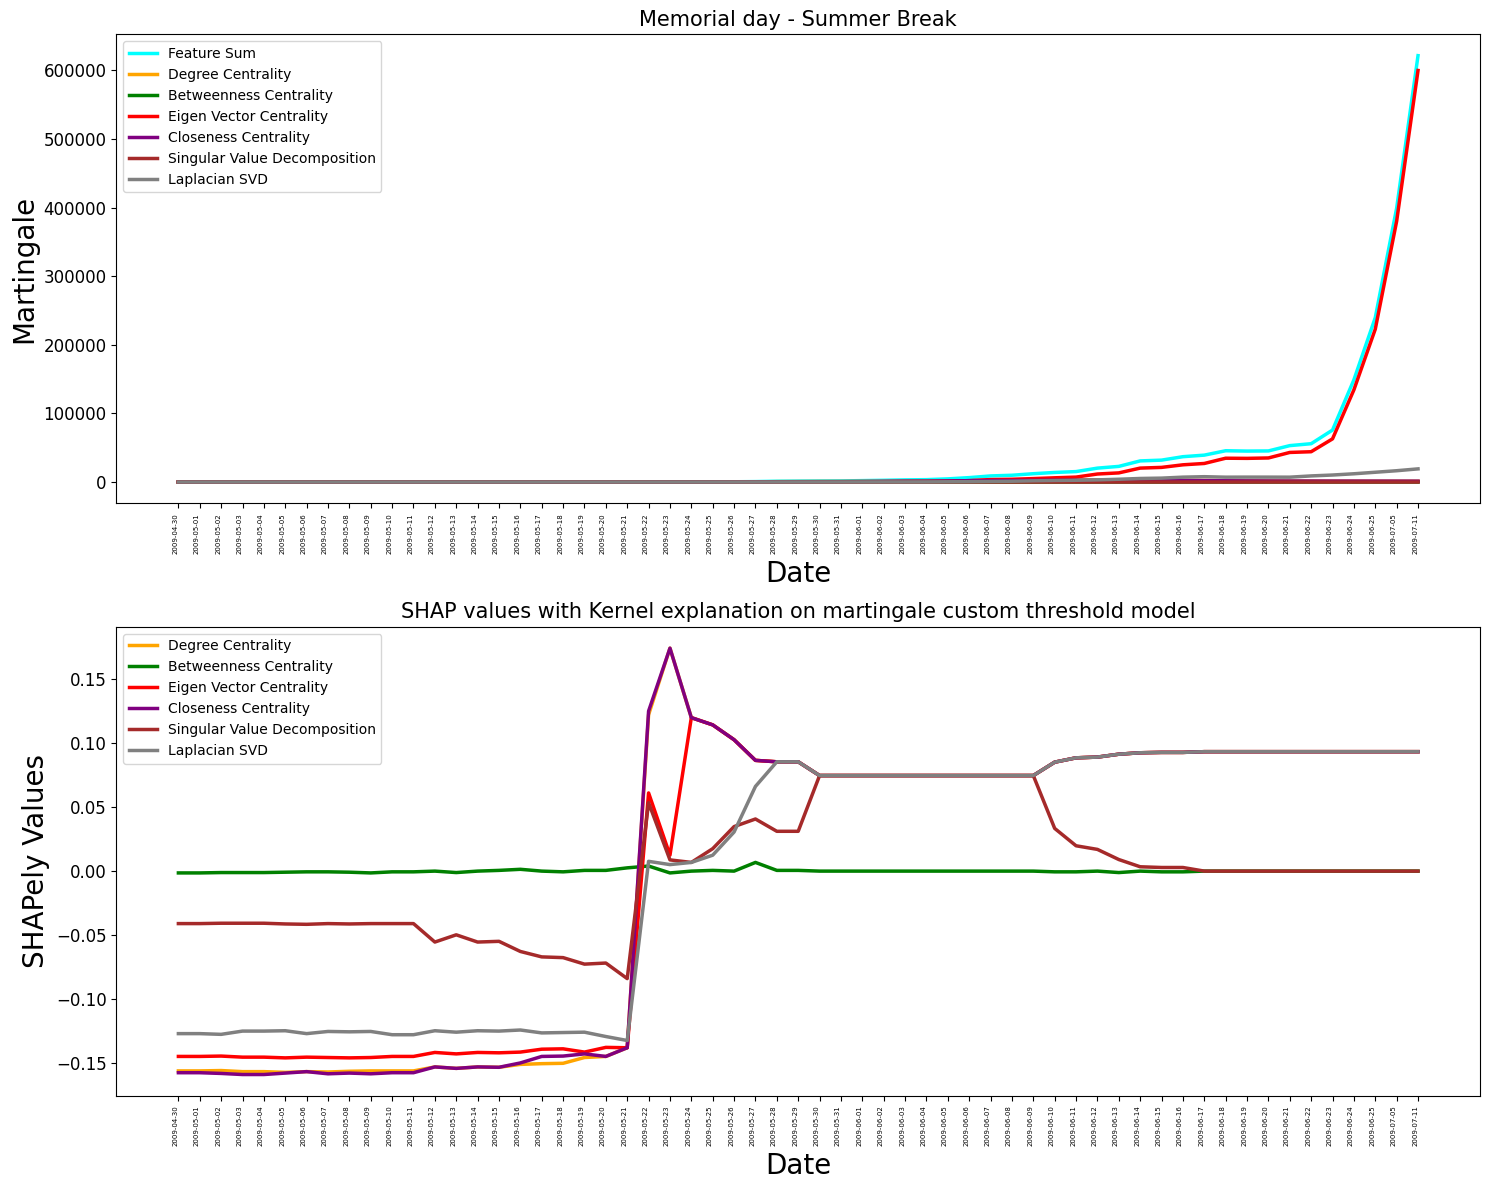

In [124]:
dates_Thanksgiving = filtered_dates.astype(str)[230:300]
plt.figure(figsize=(15, 12))

plt.subplot(2,1,1)

plt.xlabel('Date', fontsize = 20)
plt.ylabel('Martingale', fontsize = 20)
plt.legend(fontsize = 15)
plt.title('Memorial day - Summer Break', fontsize = 15)

ax = sns.lineplot(y = Msum_tg, x= dates_Thanksgiving, color = 'cyan', label='Feature Sum', linewidth = 2.5)

sns.lineplot(y = Mdc_tg['martingales'], x = dates_Thanksgiving, color = 'orange', label='Degree Centrality', linewidth = 2.5)
sns.lineplot(y = Mbc_tg['martingales'], x = dates_Thanksgiving, color = 'green', label='Betweenness Centrality', linewidth = 2.5)
sns.lineplot(y = Mev_tg['martingales'], x = dates_Thanksgiving, color = 'red', label='Eigen Vector Centrality', linewidth = 2.5)
sns.lineplot(y = Mcc_tg['martingales'], x = dates_Thanksgiving, color = 'purple', label='Closeness Centrality', linewidth = 2.5)
sns.lineplot(y = Msvd_tg['martingales'], x = dates_Thanksgiving, color = 'brown', label='Singular Value Decomposition', linewidth = 2.5)
sns.lineplot(y = Mlsvd_tg['martingales'], x = dates_Thanksgiving, color = 'gray', label='Laplacian SVD', linewidth = 2.5)


ax.set_xticklabels(labels=dates_Thanksgiving, rotation=90, ha='right')
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=12)


plt.subplot(2,1,2)

plt.xlabel('Date', fontsize = 20)
plt.ylabel('SHAPely Values', fontsize = 20)
plt.legend(fontsize = 15)
plt.title('SHAP values with Kernel explanation on martingale custom threshold model', fontsize = 15)


ax = sns.lineplot(y = shap_values4[:,0], x = dates_Thanksgiving, color = 'orange', label='Degree Centrality', linewidth = 2.5)

sns.lineplot(y = shap_values4[:,1], x = dates_Thanksgiving, color = 'green', label='Betweenness Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values4[:,2], x = dates_Thanksgiving, color = 'red', label='Eigen Vector Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values4[:,3], x = dates_Thanksgiving, color = 'purple', label='Closeness Centrality', linewidth = 2.5)
sns.lineplot(y = shap_values4[:,4], x = dates_Thanksgiving, color = 'brown', label='Singular Value Decomposition', linewidth = 2.5)
sns.lineplot(y = shap_values4[:,5], x = dates_Thanksgiving, color = 'gray', label='Laplacian SVD', linewidth = 2.5)


ax.set_xticklabels(labels=dates_Thanksgiving, rotation=90, ha='right')
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=12)

# plt.title('Martingales for MIT dataset', fontsize = 20)

plt.tight_layout()
plt.show()

# Evaluating Metrics with F1 score, Delay Times

In [152]:

def runMultipleMartingaleTest(adj_matrices, threshold = 20):
  change_detected_instants = []
  Obj = ChangePointDetection(adj_matrices)
  dc = Obj.deg_centrality(adj_matrices)
  bc = Obj.betweenness_centrality(adj_matrices)
  ev = Obj.eigenvector_centrality(adj_matrices)
  cc = Obj.closeness_centrality(adj_matrices)
  svd = Obj.SVDEmbedding(adj_matrices)
  lsvd = Obj.LSVDembedding(adj_matrices)

  Mdc = Obj.martingaleTest(dc, threshold= 20)
  Mbc = Obj.martingaleTest(bc, threshold= 20)
  Mev = Obj.martingaleTest(ev, threshold= 20)
  Mcc = Obj.martingaleTest(cc, threshold= 20)
  Msvd = Obj.martingaleTest(svd, threshold= 20)
  Mlsvd = Obj.martingaleTest(lsvd, threshold= 20)

  Msum = Mdc['martingales'] + Mbc['martingales'] + Mev['martingales'] + Mcc['martingales'] + Msvd['martingales'] + Mlsvd['martingales']

  for m in range(len(Msum)):
    if Msum[m] > threshold:
      change_detected_instants.append(m)
      summary_df = pd.DataFrame({'Martingale Sum': Msum,
                                 'Is Anomaly (Msum)': [True if x in change_detected_instants else False for x in range(len(adj_matrices))],
                                 'Martingale DC' : Mdc['martingales'],
                                 'Is Anomaly (Mdc)' : [True if x in Mdc['change_detected_instant'] else False for x in range(len(adj_matrices))],
                                 'Martingale BC' : Mbc['martingales'],
                                 'Is Anomaly (Mbc)' : [True if x in Mbc['change_detected_instant'] else False for x in range(len(adj_matrices))],
                                 'Martingale EV' : Mev['martingales'],
                                 'Is Anomaly (Mev)' : [True if x in Mev['change_detected_instant'] else False for x in range(len(adj_matrices))],
                                 'Martingale CC' : Mcc['martingales'],
                                 'Is Anomaly (Mcc)' : [True if x in Mcc['change_detected_instant'] else False for x in range(len(adj_matrices))],
                                 'Martingale SVD' : Msvd['martingales'],
                                 'Is Anomaly (Msvd)' : [True if x in Msvd['change_detected_instant'] else False for x in range(len(adj_matrices))],
                                 'Martingale LSVD' : Mlsvd['martingales'],
                                 'Is Anomaly (Mlsvd)' : [True if x in Mlsvd['change_detected_instant'] else False for x in range(len(adj_matrices))],
                                 })
  return summary_df



In [153]:
the_df = runMultipleMartingaleTest(graphs_type_1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.4720230999693035, 0.5126081460752491, 0.1896215011793386, 0.3784429968740331, 0.5491276971414056, 0.6247224413875231, 0.8757014727255422, 0.055658072499108494, 0.4898922718308797, 0.9431135363406465, 0.3255195111410267, 0.31585398625364997, 0.9193036338499447, 0.9884313654135485, 0.8674670078280902, 0.6346776761662645, 0.9566256372283524, 0.21560437123278767, 0.9419906006191724, 0.7048965181456008, 0.5114289866561438, 0.77087600137307, 0.04627837079790635, 0.49153721637882253, 0.9072129044693866, 0.6557679435368716, 0.40514576579786904, 0.1500002909814492, 0.9032971761413908, 0.7117801203788058, 0.9058870149453503, 0.9191261632848805, 0.31158649848633246, 0.6016240437334134, 0.7175980451473277, 0.48590361706107754, 0.41856118887562327, 0.5730323758345762, 0.7250285388050143, 0.10229631663113038, 0.8691290965412898, 0.4539490603457676, 0.7306600847653361, 0.23335141968485698, 0.17817465763194704, 0.14559646612893756, 0.23763658788956465, 0.4

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.2624617861445082, 0.6198453582813146, 0.2908549322074017, 0.38560511486733584, 0.8192865570082786, 0.986792435605723, 0.8587700806382416, 0.2811809075613359, 0.25338223862688136, 0.9468365788451312, 0.15285353050871542, 0.27341603989963953, 0.39072903965485223, 0.8016221191630358, 0.9389344344656984, 0.6011814430603396, 0.977921317319393, 0.561005028043681, 0.6924328080053692, 0.9561560855229487, 0.554328361337238, 0.7619408062053806, 0.025198856483298452, 0.2932806578667407, 0.8919643008321516, 0.8648782191216149, 0.49383851444260607, 0.2573164997324457, 0.6956913164279691, 0.7180406905926696, 0.6943305120370876, 0.6652949186204774, 0.800389678063653, 0.5116807009689132, 0.5018182602991088, 0.7677701051379271, 0.41042549984130977, 0.5829903456206155, 0.9439256942538724, 0.3015203431681681, 0.7617095610324122, 0.225807967747827, 0.31522330814474314, 0.3954837474677816, 0.3733142933043426, 0.11473643375935177, 0.8612242854891314, 0.244940961

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: []
Pvalues : [0.21905502269152322, 0.996302129220296, 0.12686773307413177, 0.560753944478034, 0.7265482118735042, 0.7425763440614835, 0.9269006462233415, 0.772668796756318, 0.39086756541223633, 0.905222430025345, 0.7572115293019613, 0.1684693495529386, 0.429833406185848, 0.9506698856711838, 0.962332153180375, 0.5159834852856479, 0.9735849066949909, 0.3151304501444798, 0.8594481429099128, 0.6601521229535139, 0.5476501699710282, 0.758085704837828, 0.11002960121346014, 0.617363034377299, 0.7503971089980892, 0.7496254480948138, 0.6613871937466343, 0.08901188656542233, 0.9748058228582722, 0.9111602873750189, 0.9529400738380821, 0.8168872872489884, 0.44788742948544413, 0.6615502689712187, 0.749447978359068, 0.5314712561472849, 0.2122148767188932, 0.5765410292298505, 0.5547710857924729, 0.5409435254983044, 0.6772889252732253, 0.5903885046603948, 0.6152647325310157, 0.2565885678734289, 0.2169156848581112, 0.11957340518966562, 0.315519772325191, 0.6220856587430117,

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

CHANGE DETECTED


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: [113]
Pvalues : [0.014369738265128773, 0.8374916339339391, 0.2863377818120282, 0.2547997751929466, 0.4444705128119052, 0.6942709850724059, 0.8650249844594169, 0.07997287409700268, 0.4867211715740004, 0.9065732816512071, 0.8510647498403325, 0.3807099135232808, 0.8004797061524724, 0.9928061074932296, 0.9223187744042279, 0.6415170547410118, 0.941460840272577, 0.20064639199112635, 0.9013640022366886, 0.7955069431706026, 0.2221874088906297, 0.7956621953046784, 0.06270839958926552, 0.49891390168153554, 0.8913213613900912, 0.6547839756450925, 0.2482624772844259, 0.14581524218992584, 0.8951294391844411, 0.7089139544936077, 0.9217920709354266, 0.9338800216433583, 0.2665081675585076, 0.5597918874948989, 0.7298093751790733, 0.43334318747274175, 0.49322161508296736, 0.5390312980500731, 0.8824044528381847, 0.04261726006922285, 0.8144892722978578, 0.622849408141857, 0.845988744922188, 0.22542775505422838, 0.17307309507674698, 0.12567525245847003, 0.2868504573926329, 0.5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

CHANGE DETECTED


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: [113]
Pvalues : [0.856516447881319, 0.4399861254575518, 0.9360604819484927, 0.009551114708747754, 0.7152382598264415, 0.03073021447158329, 0.9972410325415254, 0.5725121324215151, 0.9615088307525047, 0.7020784583513109, 0.23434044594904738, 0.006316821485280649, 0.5179953441416191, 0.32099890475168014, 0.80612161342569, 0.04945291664047787, 0.7096984921056644, 0.28915902482655526, 0.7151575948164234, 0.5530999757888224, 0.8574653319225101, 0.13328763885061495, 0.013956643297294359, 0.6324579568777889, 0.9275566457173654, 0.2877224610710598, 0.7354976076755919, 0.27132425392796855, 0.5887232759496537, 0.7238390959440264, 0.833189638896251, 0.8442275445042162, 0.4199232810615582, 0.6785896001127133, 0.5095067545298062, 0.06038804244477574, 0.4005934080409131, 0.6475591127843606, 0.6910870927403159, 0.10768860961022811, 0.7257123988031533, 0.26895353442660824, 0.5566893570907264, 0.9781895173691806, 0.48736003942347467, 0.3676699370456704, 0.04629091212981409,

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

CHANGE DETECTED


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Changes detected at instants: [112]
Pvalues : [0.8493258487973062, 0.8372328593656193, 0.6786028628956275, 0.17371050063972318, 0.6126213370466289, 0.10442784703033776, 0.6786220157970208, 0.09110768724763108, 0.35557570575984, 0.6913889270337863, 0.17366050259611726, 0.4882437969368183, 0.5535976827366141, 0.8909412987256727, 0.22195723021809904, 0.7209254718396935, 0.5713266198707329, 0.3488898420130234, 0.27134859856891363, 0.6267764320371634, 0.5584301330511114, 0.5949972023197325, 0.6166033491622032, 0.9992163823452979, 0.8364374092536998, 0.41585392289197654, 0.4042686947568629, 0.05458500923056765, 0.5108411798281532, 0.26019939281372856, 0.5924375663183598, 0.6987078644201312, 0.12982125934914207, 0.4573173657852304, 0.09611036734447617, 0.499039957769707, 0.4823368891314778, 0.9043928712354973, 0.3193550405364452, 0.03447378322364135, 0.9343809124998138, 0.15303123564684779, 0.17136883958041993, 0.2640555099755093, 0.599078818576867, 0.4971465150313959, 0.15615697295912573, 0.

In [156]:
the_df[the_df['Is Anomaly (Msum)'] == True]

,Martingale Sum,Is Anomaly (Msum),Martingale DC,Is Anomaly (Mdc),Martingale BC,Is Anomaly (Mbc),Martingale EV,Is Anomaly (Mev),Martingale CC,Is Anomaly (Mcc),Martingale SVD,Is Anomaly (Msvd),Martingale LSVD,Is Anomaly (Mlsvd)
106,23.178996,True,2.042232,False,0.291801,False,0.011361,False,6.681810,False,6.205404,False,7.946389,False
107,28.186840,True,2.460661,False,0.255672,False,0.009433,False,7.823060,False,8.368242,False,9.269772,False
108,32.630503,True,2.841555,False,0.224380,False,0.007898,False,9.131109,False,9.567182,False,10.858379,False
109,42.034129,True,3.858786,False,0.195685,False,0.006683,False,12.549561,False,12.293224,False,13.130191,False
110,44.309502,True,4.043221,False,0.158809,False,0.005359,False,13.066206,False,13.152330,False,13.883577,False
111,51.458283,True,4.697924,False,0.134182,False,0.004294,False,14.471023,False,13.853771,False,18.297090,False
112,62.130390,True,5.522102,False,0.114130,False,0.003615,False,18.461254,False,16.104181,False,21.925107,True
113,79.774430,True,8.827660,False,0.101939,False,0.002958,False,39.006283,True,30.918556,True,0.917034,False


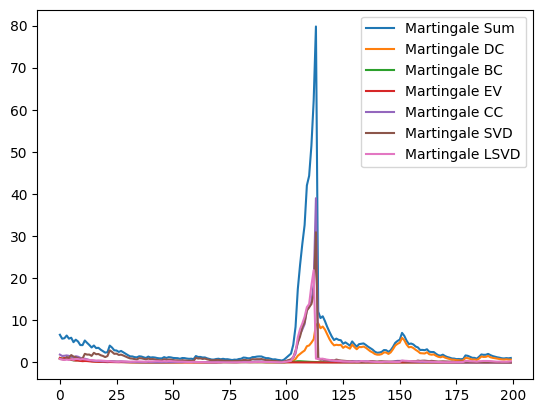

In [155]:
plt.plot(the_df['Martingale Sum'])
plt.plot(the_df['Martingale DC'])
plt.plot(the_df['Martingale BC'])
plt.plot(the_df['Martingale EV'])
plt.plot(the_df['Martingale CC'])
plt.plot(the_df['Martingale SVD'])
plt.plot(the_df['Martingale LSVD'])

plt.legend(['Martingale Sum', 'Martingale DC', 'Martingale BC', 'Martingale EV', 'Martingale CC', 'Martingale SVD', 'Martingale LSVD'])